# DATA PREPROCESSING

In this code we will fetch the missing datas about the stock like importing the Sectors and Industry of the stock they are trading, buy and sell time and date. Preprocess the data, perform Data Cleaning, perform Exploratory Data Analysis and at last will do Feature Engineering to find the hidden patterns and trends in the data.

Now we will import the necessary libaries.

In [1723]:
import pandas as pd
import numpy as np  
import yfinance as yf
from datetime import datetime  
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns

Now we will load the Dataset to Preprocess.

In [1724]:
import pandas as pd

def load_clean_excel(file_path, start_keywords=['Stock name'], end_keywords=['Unrealised trades', 'Disclaimer']):
    # Preview file to find header and footer
    preview = pd.read_excel(file_path, header=None)
    
    # Find where the actual table starts
    start_mask = preview.apply(lambda row: row.astype(str).str.contains('|'.join(start_keywords), case=False, na=False)).any(axis=1)
    start_index = start_mask[start_mask].index.min()
    
    # Find where table ends
    end_mask = preview.apply(lambda row: row.astype(str).str.contains('|'.join(end_keywords), case=False, na=False)).any(axis=1)
    end_index = end_mask[end_mask].index.min() if end_mask.any() else len(preview)
    
    print(f"{file_path}")
    print(f"Data starts at row {start_index}, ends before row {end_index}")
    
    # Read only the relevant data rows
    df = pd.read_excel(file_path, header=start_index, nrows=end_index - start_index - 1)
    
    # Clean column names
    df.columns = (df.columns
                  .astype(str)
                  .str.strip()
                  .str.replace('\u00A0', ' ', regex=True)
                  .str.replace('\s+', ' ', regex=True))
    
    # Drop empty rows/columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    
    print(f" Clean Data Loaded — Shape: {df.shape}\n")
    return df


# Step 1: File Paths
pnl_path = "Stocks_PnL_Report_3788142010_01-10-2020_06-11-2025.xlsx"
order_path = "Stocks_Order_History_3788142010_01-10-2020_06-11-2025.xlsx"

# Step 2: Load both files dynamically
pnl = load_clean_excel(pnl_path)
order_history = load_clean_excel(order_path)

# Step 3: Verify loaded datasets
print("PnL Columns:", pnl.columns.tolist())
print("Order History Columns:", order_history.columns.tolist())

# Optional — display samples
print("\nPnL Preview:")
print(pnl.head(3))

print("\nOrder History Preview:")
print(order_history.head(3))


Stocks_PnL_Report_3788142010_01-10-2020_06-11-2025.xlsx
Data starts at row 25, ends before row 251
 Clean Data Loaded — Shape: (224, 11)

Stocks_Order_History_3788142010_01-10-2020_06-11-2025.xlsx
Data starts at row 5, ends before row 402
 Clean Data Loaded — Shape: (396, 10)

PnL Columns: ['Stock name', 'ISIN', 'Quantity', 'Buy date', 'Buy price', 'Buy value', 'Sell date', 'Sell price', 'Sell value', 'Realised P&L', 'Remark']
Order History Columns: ['Stock name', 'Symbol', 'ISIN', 'Type', 'Quantity', 'Value', 'Exchange', 'Exchange Order Id', 'Execution date and time', 'Order status']

PnL Preview:
                  Stock name          ISIN  Quantity    Buy date  Buy price  \
0  ONE 97 COMMUNICATIONS LTD  INE982J01020         1  25-11-2021    1833.55   
1        INDIAN OIL CORP LTD  INE242A01010        10  30-05-2022     114.40   
2             COAL INDIA LTD  INE522F01014         1  02-06-2022     195.50   

   Buy value   Sell date  Sell price  Sell value  Realised P&L          Remar

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\1550857535.py:26: SyntaxWarning: invalid escape sequence '\s'
  .str.replace('\s+', ' ', regex=True))
C:\Users\kejri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kejri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kejri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-pa

Now let's find some information about the data

In [1725]:
pnl.info()
pnl.shape
pnl.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stock name    224 non-null    object 
 1   ISIN          224 non-null    object 
 2   Quantity      224 non-null    int64  
 3   Buy date      224 non-null    object 
 4   Buy price     224 non-null    float64
 5   Buy value     224 non-null    float64
 6   Sell date     224 non-null    object 
 7   Sell price    224 non-null    float64
 8   Sell value    224 non-null    float64
 9   Realised P&L  224 non-null    float64
 10  Remark        153 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 19.4+ KB


,Quantity,Buy price,Buy value,Sell price,Sell value,Realised P&L
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,10.848214,880.041250,6474.073482,882.256429,6609.405804,135.332321
std,13.936248,896.907418,6810.764111,867.502117,6895.331850,787.631269
min,1.000000,0.000000,0.000000,27.640000,72.600000,-2329.400000
25%,4.000000,198.112500,1438.927500,198.500000,1425.737500,-43.750000
50%,9.000000,644.475000,4212.750000,649.140000,4405.700000,-0.630000
75%,10.000000,1399.975000,9740.125000,1416.000000,9846.937500,50.825000
max,100.000000,5466.000000,32465.000000,5085.250000,32439.000000,7202.000000


similarly for the Order's history

In [1726]:
order_history.info()
order_history.shape
order_history.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Stock name               396 non-null    object 
 1   Symbol                   396 non-null    object 
 2   ISIN                     396 non-null    object 
 3   Type                     396 non-null    object 
 4   Quantity                 396 non-null    int64  
 5   Value                    396 non-null    float64
 6   Exchange                 396 non-null    object 
 7   Exchange Order Id        396 non-null    int64  
 8   Execution date and time  396 non-null    object 
 9   Order status             396 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 31.1+ KB


,Quantity,Value,Exchange Order Id
count,396.000000,396.000000,3.960000e+02
mean,12.300505,7400.965000,4.023615e+16
std,16.096170,7501.459137,2.570357e+17
min,1.000000,0.700000,8.247315e+06
25%,4.000000,1686.850000,1.000000e+15
50%,10.000000,5011.725000,1.100000e+15
75%,10.250000,11811.300000,1.200000e+15
max,138.000000,44490.000000,1.755493e+18


Now Let's see how the data looks 

In [1727]:
pnl.head()
pnl.sample(5)

,Stock name,ISIN,Quantity,Buy date,Buy price,Buy value,Sell date,Sell price,Sell value,Realised P&L,Remark
221,BLACK BOX LIMITED,INE676A01027,25,24-03-2025,370.65,9266.25,17-09-2025,489.45,12236.25,2970.0,NaN
152,PUNJAB NATIONAL BANK,INE160A01022,15,22-03-2024,122.90,1843.50,22-03-2024,122.90,1843.50,0.0,Intraday trade
115,PUNJAB NATIONAL BANK,INE160A01022,30,20-01-2024,103.45,3103.50,10-06-2024,125.44,3763.20,659.7,NaN
156,JINDAL STEEL LIMITED,INE749A01030,2,02-04-2024,897.45,1794.90,31-05-2024,1017.90,2035.80,240.9,NaN
136,HDFC BANK LTD,INE040A01034,10,20-02-2024,1443.35,14433.50,20-02-2024,1435.85,14358.50,-75.0,Intraday trade


Similarly for the Order history

In [1728]:
order_history.head()
order_history.sample(5)

,Stock name,Symbol,ISIN,Type,Quantity,Value,Exchange,Exchange Order Id,Execution date and time,Order status
340,SAMVRDHNA MTHRSN INTL LTD,MOTHERSON,INE775A01035,SELL,25,4633.50,NSE,1200000058038733,20-06-2024 03:07 PM,Executed
330,BAJAJ HINDUSTHAN SUGAR LT,BAJAJHIND,INE306A01021,BUY,5,178.65,NSE,1000000033842044,11-06-2024 01:56 PM,Executed
107,COAL INDIA LTD,COALINDIA,INE522F01014,BUY,40,10340.00,NSE,1000000007714751,09-11-2022 10:29 AM,Executed
247,RELIANCE INDUSTRIES LTD,RELIANCE,INE002A01018,BUY,10,29422.00,NSE,1300000007273570,29-02-2024 09:43 AM,Executed
67,STEEL AUTHORITY OF INDIA,SAIL,INE114A01011,BUY,5,374.25,NSE,1300000012931817,22-07-2022 01:38 PM,Executed


Let's check for the missing values and the duplicated values

In [1729]:
pnl.isnull().sum()

Stock name       0
ISIN             0
Quantity         0
Buy date         0
Buy price        0
Buy value        0
Sell date        0
Sell price       0
Sell value       0
Realised P&L     0
Remark          71
dtype: int64

In [1730]:
pnl.duplicated().sum()

np.int64(1)

Similarly for the order history

In [1731]:
order_history.isnull().sum()

Stock name                 0
Symbol                     0
ISIN                       0
Type                       0
Quantity                   0
Value                      0
Exchange                   0
Exchange Order Id          0
Execution date and time    0
Order status               0
dtype: int64

In [1732]:
order_history.duplicated().sum()

np.int64(0)

# Data Fetching

Now lets fetch the execution date and time for both the buy and sell orders from the order history to the pnl to do the further preprocesses and find the time-based analysis. 

In [1733]:
# Ensure datetime column exists and is clean
order_history.columns = order_history.columns.str.strip().str.replace('\u00A0', ' ', regex=True)
order_history['Execution date and time'] = pd.to_datetime(order_history['Execution date and time'], errors='coerce')

# Split date and time safely
order_history['Execution Date'] = order_history['Execution date and time'].dt.date
order_history['Execution Time'] = order_history['Execution date and time'].dt.time

# ---------- Step 3: Clean and convert buy/sell dates safely ----------
pnl['Buy date'] = pd.to_datetime(pnl['Buy date'], errors='coerce').dt.date
pnl['Sell date'] = pd.to_datetime(pnl['Sell date'], errors='coerce').dt.date

# Drop any rows where dates failed to parse
pnl = pnl.dropna(subset=['Buy date', 'Sell date'])

# ---------- Step 4: Define market hours helper ----------
def is_market_time(dt):
    if pd.notna(dt):
        time = dt.time()
        return (time >= pd.Timestamp('09:15:00').time()) and (time <= pd.Timestamp('15:30:00').time())
    return False

# ---------- Step 5: Function to get times from order history ----------
def get_times_from_order_history(pnl_row, order_df):
    stock_name = pnl_row['Stock name']
    isin = pnl_row['ISIN']
    buy_date = pnl_row['Buy date']
    sell_date = pnl_row['Sell date']
    
    stock_orders = order_df[
        (order_df['Stock name'] == stock_name) &
        (order_df['ISIN'] == isin)
    ].copy()
    
    # Case 1: Intraday (same date)
    if buy_date == sell_date:
        buy_order = stock_orders[
            (stock_orders['Execution date and time'].dt.date == buy_date) &
            (stock_orders['Type'].str.upper() == 'BUY') &
            (stock_orders['Execution date and time'].apply(is_market_time))
        ].sort_values('Execution date and time').head(1)
        
        sell_order = stock_orders[
            (stock_orders['Execution date and time'].dt.date == sell_date) &
            (stock_orders['Type'].str.upper() == 'SELL') &
            (stock_orders['Execution date and time'].apply(is_market_time))
        ].sort_values('Execution date and time').tail(1)
    
    # Case 2: Delivery
    else:
        buy_order = stock_orders[
            (stock_orders['Execution date and time'].dt.date == buy_date) &
            (stock_orders['Type'].str.upper() == 'BUY') &
            (stock_orders['Execution date and time'].apply(is_market_time))
        ].sort_values('Execution date and time').head(1)
        
        sell_order = stock_orders[
            (stock_orders['Execution date and time'].dt.date == sell_date) &
            (stock_orders['Type'].str.upper() == 'SELL') &
            (stock_orders['Execution date and time'].apply(is_market_time))
        ].sort_values('Execution date and time').tail(1)
    
    # Extract times or set defaults
    buy_time = buy_order['Execution date and time'].iloc[0].time() if not buy_order.empty else pd.Timestamp('09:15:00').time()
    sell_time = sell_order['Execution date and time'].iloc[0].time() if not sell_order.empty else pd.Timestamp('15:30:00').time()
    
    return buy_time, sell_time

# ---------- Step 6: Apply function ----------
pnl[['Buy Time', 'Sell Time']] = pnl.apply(
    lambda row: pd.Series(get_times_from_order_history(row, order_history)), axis=1
)

print("Buy/Sell times added successfully!")
print(pnl[['Stock name', 'Buy date', 'Buy Time', 'Sell date', 'Sell Time']].head(20))


C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\1051223471.py:3: UserWarning: Parsing dates in %d-%m-%Y %I:%M %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  order_history['Execution date and time'] = pd.to_datetime(order_history['Execution date and time'], errors='coerce')
C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\1051223471.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pnl['Buy date'] = pd.to_datetime(pnl['Buy date'], errors='coerce').dt.date
C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\1051223471.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pnl['Sell date'] = pd.to_datetime(pnl['Sell date'], errors='coerce').dt.date


Buy/Sell times added successfully!
                   Stock name    Buy date  Buy Time   Sell date Sell Time
0   ONE 97 COMMUNICATIONS LTD  2021-11-25  09:23:00  2021-11-25  09:27:00
1         INDIAN OIL CORP LTD  2022-05-30  10:29:00  2023-05-18  11:48:00
2              COAL INDIA LTD  2022-06-02  09:34:00  2022-08-08  13:54:00
3             ETERNAL LIMITED  2022-06-03  13:12:00  2022-06-03  13:07:00
4              COAL INDIA LTD  2022-06-03  10:32:00  2022-08-08  13:54:00
5       INDUSIND BANK LIMITED  2022-06-08  10:13:00  2022-08-05  15:23:00
6              COAL INDIA LTD  2022-06-09  15:11:00  2022-06-09  10:24:00
7       INDUSIND BANK LIMITED  2022-06-14  10:34:00  2022-06-14  10:41:00
8       INDUSIND BANK LIMITED  2022-06-14  10:34:00  2022-06-14  10:41:00
9              COAL INDIA LTD  2022-06-14  09:17:00  2022-06-14  10:51:00
10             COAL INDIA LTD  2022-06-14  09:17:00  2022-06-14  10:51:00
11             COAL INDIA LTD  2022-06-14  09:17:00  2022-06-14  10:51:00
12 

Similarly, now let's fetch the sectors and industry for each of the trades to find the sector-based and industry-based trends and patterns in the user trade history 

In [1734]:
# Create symbol mapping from order history (Symbol to Stock name)
symbol_to_name = dict(zip(order_history['Symbol'], order_history['Stock name']))
name_to_symbol = {v: k for k, v in symbol_to_name.items()}

# Get unique symbols from order history
unique_symbols = order_history['Symbol'].unique()

# Fetch sector data
sector_data = {}
for symbol in unique_symbols:
    try:
        ticker = yf.Ticker(f"{symbol}.NS")
        info = ticker.info
        sector_data[symbol] = (
            info.get('sector', 'Unknown'),
            info.get('industry', 'Unknown')
        )
    except Exception as e:
        print(f"Error fetching {symbol}: {str(e)}")
        sector_data[symbol] = ('Unknown', 'Unknown')

# Add to order history
order_history['Sector'] = order_history['Symbol'].map(lambda x: sector_data.get(x, ('Unknown', 'Unknown'))[0])
order_history['Industry'] = order_history['Symbol'].map(lambda x: sector_data.get(x, ('Unknown', 'Unknown'))[1])

# Add to PnL - first extract symbol from stock name
pnl['Symbol'] = pnl['Stock name'].map(name_to_symbol)
pnl['Sector'] = pnl['Symbol'].map(lambda x: sector_data.get(x, ('Unknown', 'Unknown'))[0])
pnl['Industry'] = pnl['Symbol'].map(lambda x: sector_data.get(x, ('Unknown', 'Unknown'))[1])

print("Sector and Industry data added successfully!")

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: STANCAP$.NS"}}}


Sector and Industry data added successfully!


Since we imported the necessary Timing and Sectorial datas for the trades, now we will be moving towards the Data Cleaning part and afterwards we will apply some EDA techniques to find some hidden patterns.  

# Data Cleaning

In [1735]:
#Let's check the information of the datasets again
pnl.info()
pnl.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stock name    224 non-null    object 
 1   ISIN          224 non-null    object 
 2   Quantity      224 non-null    int64  
 3   Buy date      224 non-null    object 
 4   Buy price     224 non-null    float64
 5   Buy value     224 non-null    float64
 6   Sell date     224 non-null    object 
 7   Sell price    224 non-null    float64
 8   Sell value    224 non-null    float64
 9   Realised P&L  224 non-null    float64
 10  Remark        153 non-null    object 
 11  Buy Time      224 non-null    object 
 12  Sell Time     224 non-null    object 
 13  Symbol        224 non-null    object 
 14  Sector        224 non-null    object 
 15  Industry      224 non-null    object 
dtypes: float64(5), int64(1), object(10)
memory usage: 28.1+ KB


(224, 16)

Since Remarks have so many missing values, lets fill them

In [1736]:
pnl['Remark'].value_counts()

Remark
Intraday trade                  143
New shares credit from IPO        8
New shares credit from Bonus      2
Name: count, dtype: int64

In [1737]:
pnl['Remark'] = pnl['Remark'].fillna('Delivery Trade')
pnl['Remark'].value_counts()

Remark
Intraday trade                  143
Delivery Trade                   71
New shares credit from IPO        8
New shares credit from Bonus      2
Name: count, dtype: int64

Since we have duplicate values, let's deal with them

In [1738]:
pnl = pnl.drop_duplicates()
pnl.duplicated().sum()
pnl.shape

(223, 16)

Let's handle the missing Sector and Industry names.

In [1739]:
pnl['Sector'].to_list()
pnl['Sector'] = pnl['Sector'].replace(['Unknown', ''], 'Others')

In [1740]:
pnl['Industry'].to_list()
pnl['Industry'] = pnl['Industry'].replace(['Unknown', ''], 'Others')

# Exploratory Data Analysis

In [1741]:
pnl.info()
pnl.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 0 to 223
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stock name    223 non-null    object 
 1   ISIN          223 non-null    object 
 2   Quantity      223 non-null    int64  
 3   Buy date      223 non-null    object 
 4   Buy price     223 non-null    float64
 5   Buy value     223 non-null    float64
 6   Sell date     223 non-null    object 
 7   Sell price    223 non-null    float64
 8   Sell value    223 non-null    float64
 9   Realised P&L  223 non-null    float64
 10  Remark        223 non-null    object 
 11  Buy Time      223 non-null    object 
 12  Sell Time     223 non-null    object 
 13  Symbol        223 non-null    object 
 14  Sector        223 non-null    object 
 15  Industry      223 non-null    object 
dtypes: float64(5), int64(1), object(10)
memory usage: 29.6+ KB


,Quantity,Buy price,Buy value,Sell price,Sell value,Realised P&L
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,10.852018,883.488296,6498.111928,885.823274,6635.149776,137.037848
std,13.967484,897.436877,6816.555967,867.805959,6900.046776,788.988551
min,1.000000,0.000000,0.000000,27.640000,72.600000,-2329.400000
25%,4.000000,199.200000,1448.010000,200.025000,1434.750000,-42.235000
50%,9.000000,644.900000,4212.750000,649.500000,4411.400000,-0.600000
75%,10.000000,1400.300000,9742.750000,1416.000000,9948.375000,51.150000
max,100.000000,5466.000000,32465.000000,5085.250000,32439.000000,7202.000000


Before Proceedings we will find the Buy Hour, Buy Month, Buy Year, and similarly will find for the Selling.

In [1742]:
pnl['Buy date'] = pd.to_datetime(pnl['Buy date'])
pnl['Sell date'] = pd.to_datetime(pnl['Sell date'])

pnl['Buy Year'] = pnl['Buy date'].dt.year.astype('int64')
pnl['Buy Month'] = pnl['Buy date'].dt.strftime('%b').astype('object')
pnl['Buy Day'] = pnl['Buy date'].dt.day.astype('int64')
pnl['Buy Day of Week'] = pnl['Buy date'].dt.strftime('%A').astype('object')

pnl['Sell Year'] = pnl['Sell date'].dt.year.astype('int64')
pnl['Sell Month'] = pnl['Sell date'].dt.strftime('%b').astype('object')
pnl['Sell Day'] = pnl['Sell date'].dt.day.astype('int64')
pnl['Sell Day of Week'] = pnl['Sell date'].dt.strftime('%A').astype('object')

if 'Buy Time' in pnl.columns:
    pnl['Buy Time'] = pd.to_datetime(pnl['Buy Time'], format='%H:%M:%S', errors='coerce')
    pnl['Buy Hour'] = pnl['Buy Time'].dt.hour.astype('int64')
    
    pnl['Buy Interval'] = pnl['Buy Time'].apply(lambda x: 
        f"{x.hour:02d}:{(x.minute // 30) * 30:02d}-{x.hour if (x.minute // 30) * 30 + 30 < 60 else x.hour + 1:02d}:{(x.minute // 30) * 30 + 30 if (x.minute // 30) * 30 + 30 < 60 else 0:02d}"
        if pd.notna(x) else None
    )
    
    pnl['Buy Time'] = pnl['Buy Time'].dt.time

if 'Sell Time' in pnl.columns:
    pnl['Sell Time'] = pd.to_datetime(pnl['Sell Time'], format='%H:%M:%S', errors='coerce')
    pnl['Sell Hour'] = pnl['Sell Time'].dt.hour.astype('int64')
    
    pnl['Sell Interval'] = pnl['Sell Time'].apply(lambda x: 
        f"{x.hour:02d}:{(x.minute // 30) * 30:02d}-{x.hour if (x.minute // 30) * 30 + 30 < 60 else x.hour + 1:02d}:{(x.minute // 30) * 30 + 30 if (x.minute // 30) * 30 + 30 < 60 else 0:02d}"
        if pd.notna(x) else None
    )
    
    pnl['Sell Time'] = pnl['Sell Time'].dt.time

if 'Buy Interval' in pnl.columns:
    pnl['Buy Interval'] = pnl['Buy Interval'].replace('15:30-16:00', '15:00-15:30')
    pnl['Buy Interval'] = pnl['Buy Interval'].fillna('09:00-10:00')
    pnl['Buy Interval'] = pnl['Buy Interval'].astype('object')

if 'Sell Interval' in pnl.columns:
    pnl['Sell Interval'] = pnl['Sell Interval'].replace('15:30-16:00', '15:00-15:30')
    pnl['Sell Interval'] = pnl['Sell Interval'].fillna('15:00-15:30')
    pnl['Sell Interval'] = pnl['Sell Interval'].astype('object')

pnl['Buy date'] = pd.to_datetime(pnl['Buy date']).dt.date
pnl['Sell date'] = pd.to_datetime(pnl['Sell date']).dt.date

print("="*80)
print("DATA QUALITY CHECK")
print("="*80)
print("\nMISSING VALUES:")
print("-"*80)
missing_data = pnl.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values found!")

print("\n" + "="*80)
print("DUPLICATE ROWS:")
print("-"*80)
duplicates = pnl.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")
if duplicates > 0:
    print("\nDuplicate row indices:")
    print(pnl[pnl.duplicated(keep=False)].index.tolist())

print("\n" + "="*80)
print("DATA TYPES:")
print("-"*80)
print(pnl.dtypes)


DATA QUALITY CHECK

MISSING VALUES:
--------------------------------------------------------------------------------
No missing values found!

DUPLICATE ROWS:
--------------------------------------------------------------------------------
Total duplicate rows: 0

DATA TYPES:
--------------------------------------------------------------------------------
Stock name           object
ISIN                 object
Quantity              int64
Buy date             object
Buy price           float64
Buy value           float64
Sell date            object
Sell price          float64
Sell value          float64
Realised P&L        float64
Remark               object
Buy Time             object
Sell Time            object
Symbol               object
Sector               object
Industry             object
Buy Year              int64
Buy Month            object
Buy Day               int64
Buy Day of Week      object
Sell Year             int64
Sell Month           object
Sell Day              int6

In [1743]:
pnl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 0 to 223
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stock name        223 non-null    object 
 1   ISIN              223 non-null    object 
 2   Quantity          223 non-null    int64  
 3   Buy date          223 non-null    object 
 4   Buy price         223 non-null    float64
 5   Buy value         223 non-null    float64
 6   Sell date         223 non-null    object 
 7   Sell price        223 non-null    float64
 8   Sell value        223 non-null    float64
 9   Realised P&L      223 non-null    float64
 10  Remark            223 non-null    object 
 11  Buy Time          223 non-null    object 
 12  Sell Time         223 non-null    object 
 13  Symbol            223 non-null    object 
 14  Sector            223 non-null    object 
 15  Industry          223 non-null    object 
 16  Buy Year          223 non-null    int64  
 17  Bu

1. Univariate Analysis

Let's do the Univariate Analysis for the numerical features

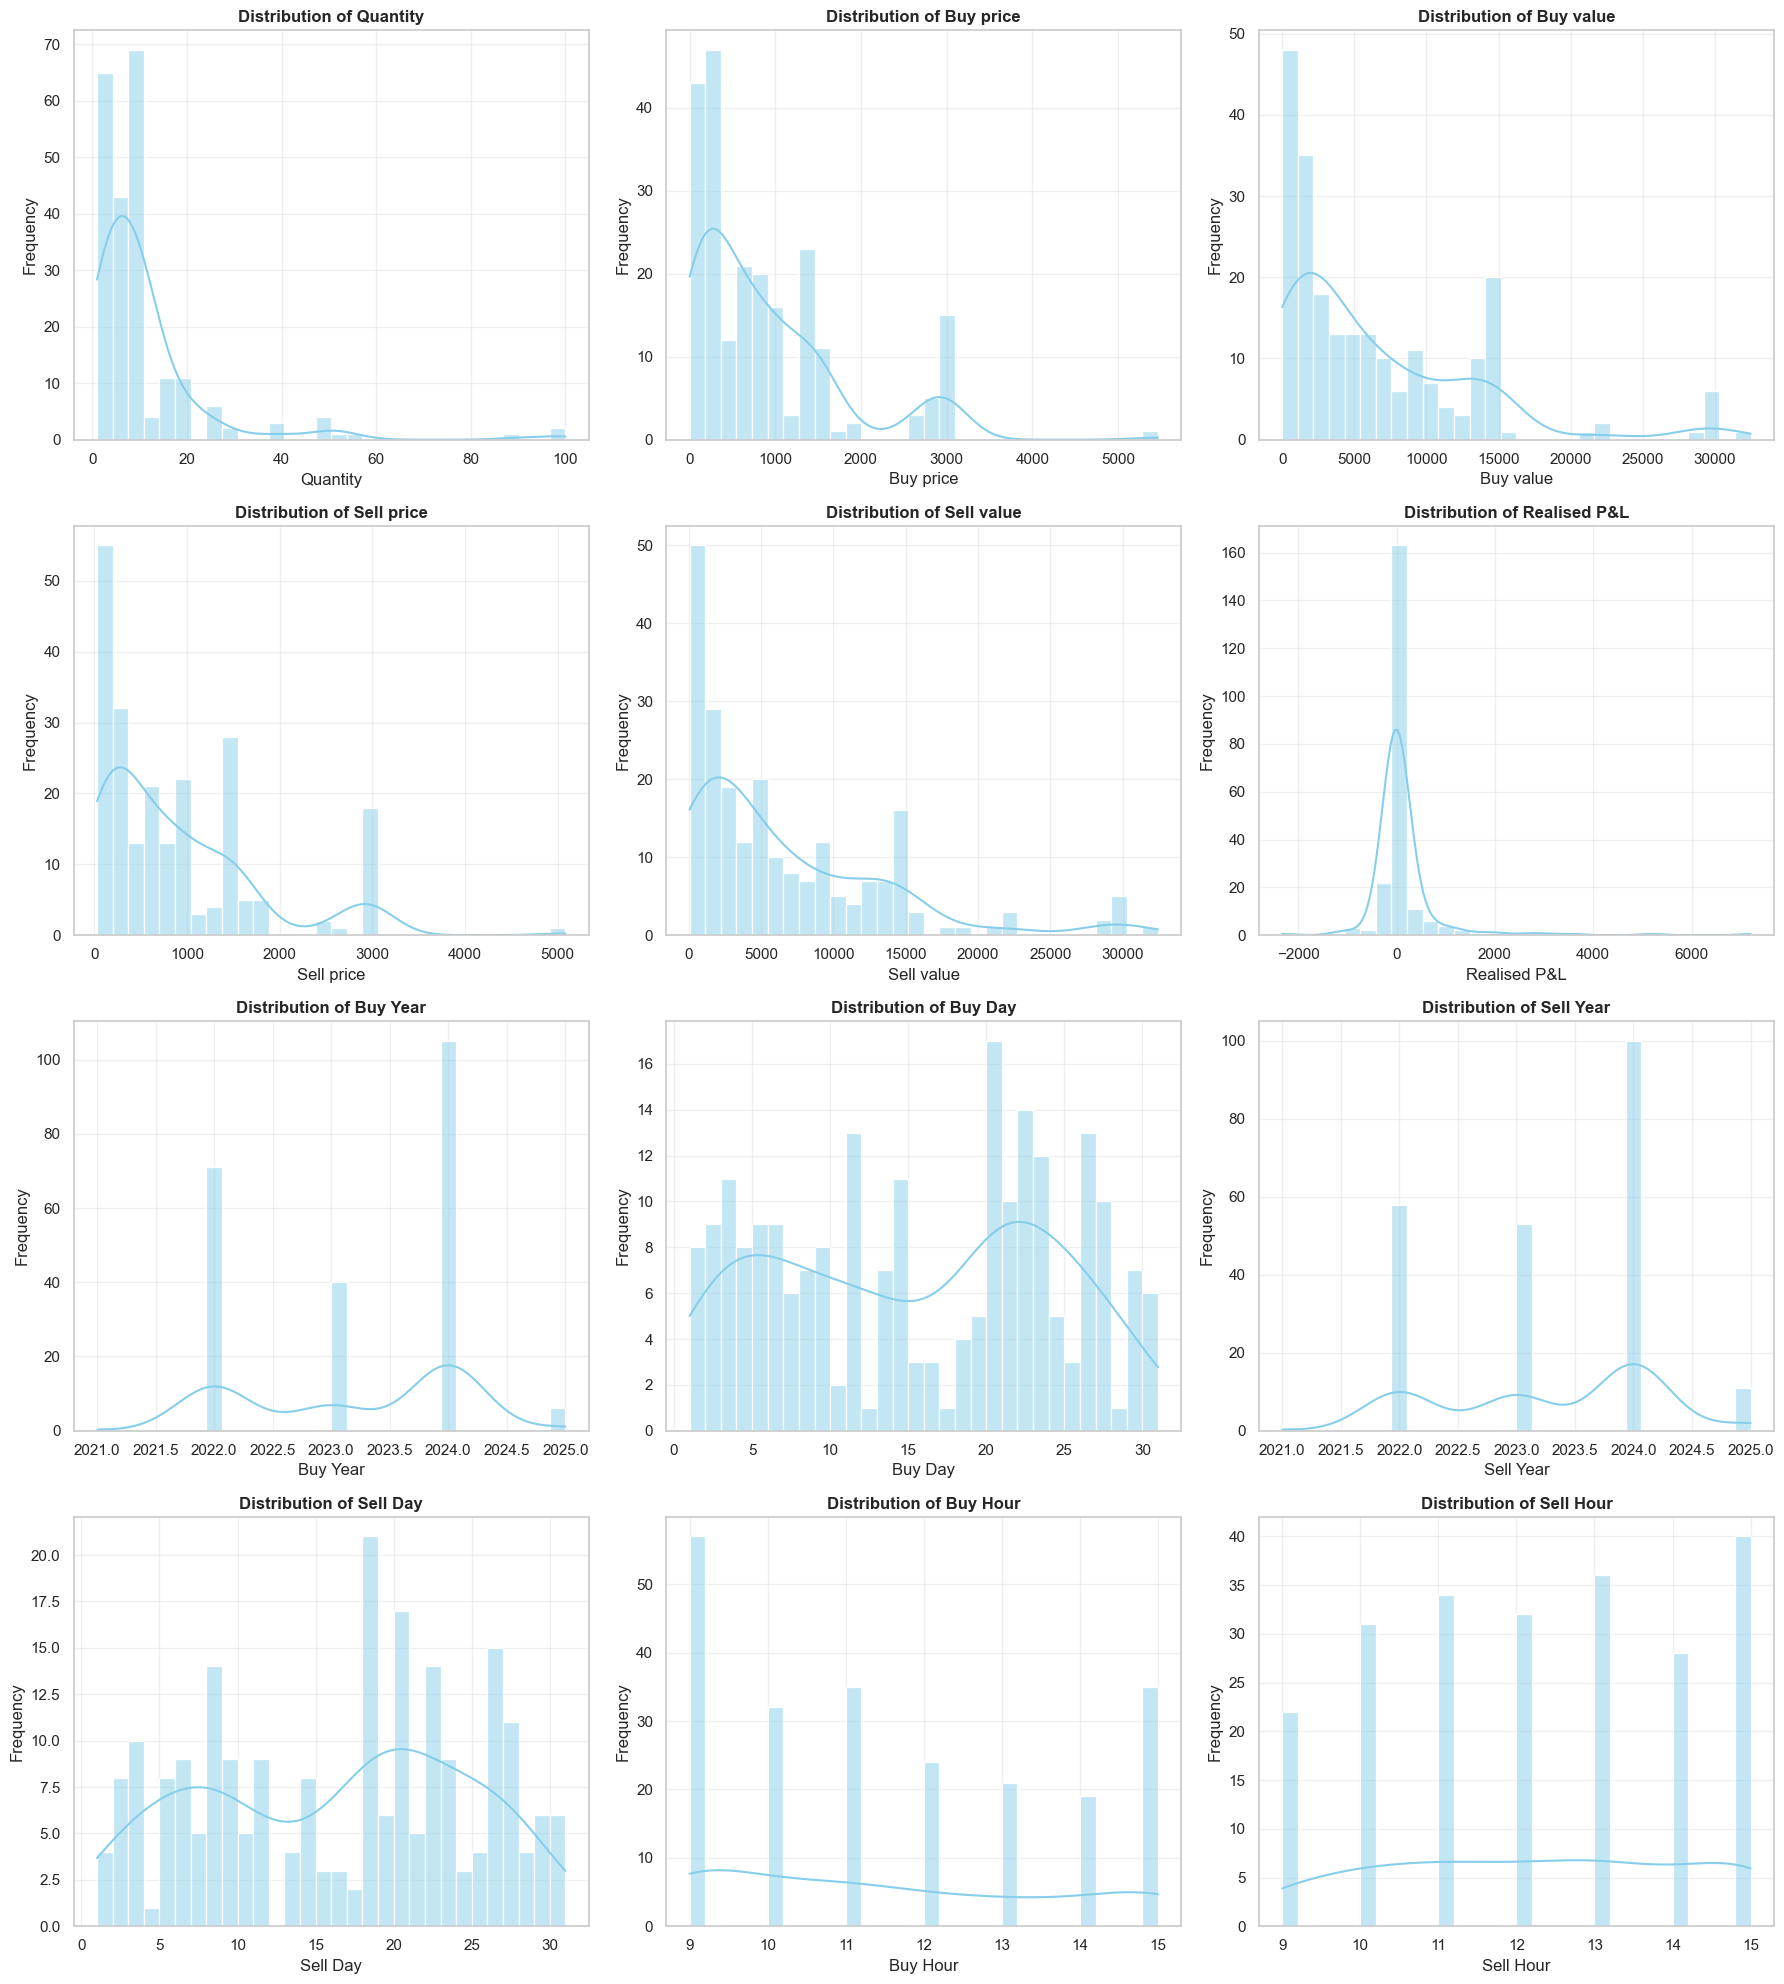

In [1744]:
# Select numeric columns
numerical_cols = pnl.select_dtypes(include=['int64', 'float64']).columns

# Dynamically set rows and columns for subplot grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(numerical_cols):
    sns.histplot(pnl[col].dropna(), kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f"Distribution of {col}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].grid(alpha=0.3)

# Remove any unused axes (in case of fewer numeric columns)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These plots tells us that there are too much skewness in the numerical cols. Also explaining that there are too much correlation between the Numerical cols

Now, let's do the Univariate Analysis for the Categorical features

In [1745]:
# Merging the Industry rows appearing less than 4 times
uncommon_industry = pnl['Industry'].value_counts() 
pnl['Industry'] = pnl['Industry'].replace(uncommon_industry[uncommon_industry < 4].index, 'Others')

In [1746]:
# Merging the Symbols rows appearing less than 5 times
uncommon_Symbols = pnl['Symbol'].value_counts() 
pnl['Symbol'] = pnl['Symbol'].replace(uncommon_Symbols[uncommon_Symbols < 4].index, 'Others')

C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\4123969910.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], palette='pastel')
C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\4123969910.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], palette='pastel')
C:\Users\kejri\AppData\Local\Temp\ipykernel_32608\4123969910.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i]

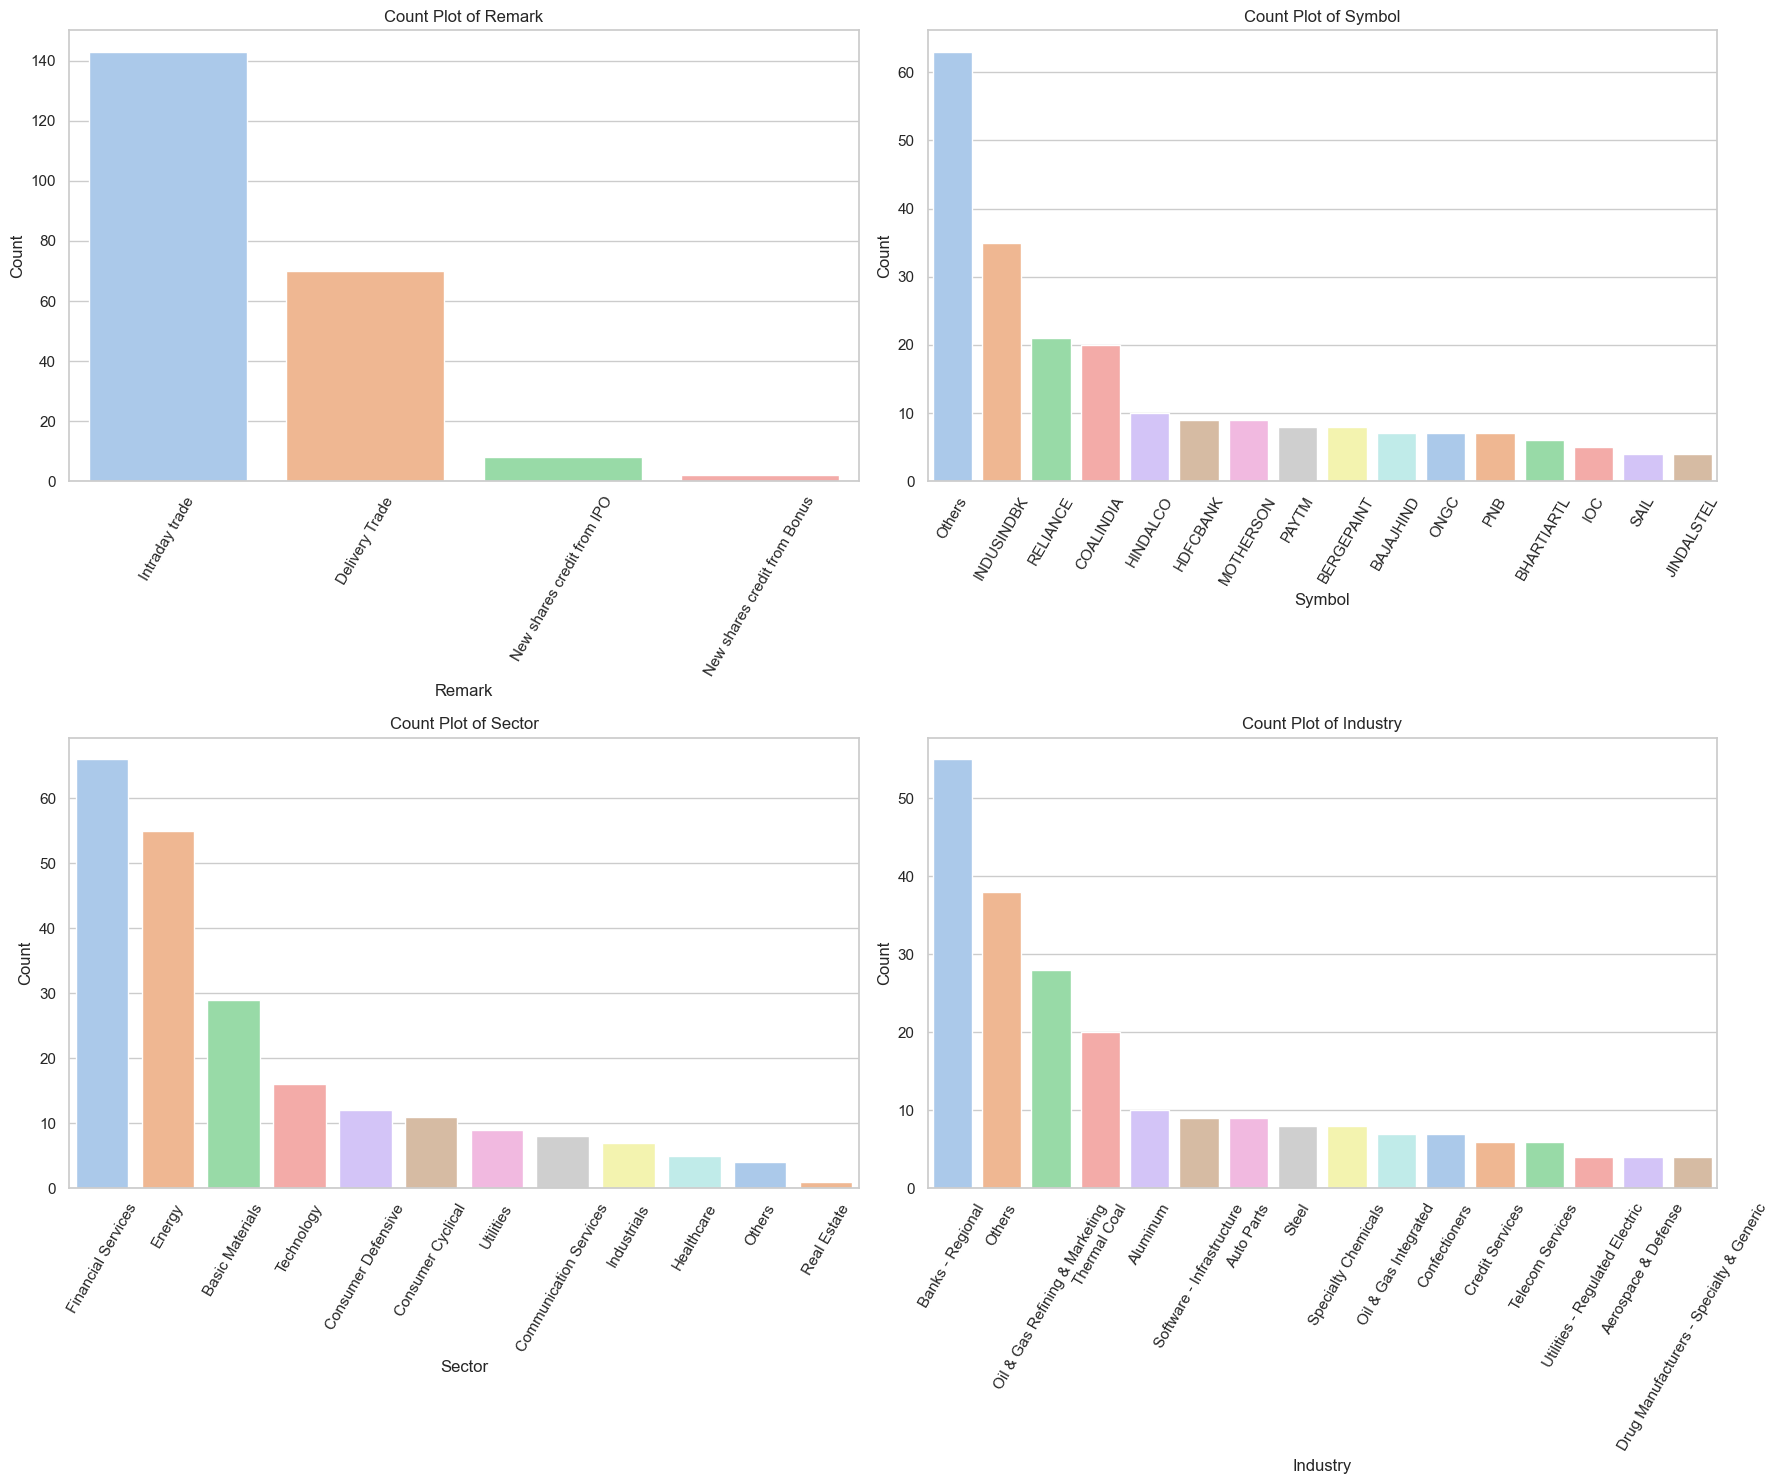

In [1747]:
categorical_cols = pnl[['Remark', 'Symbol', 'Sector', 'Industry']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
axes = axes.flatten()  # Flatten for easy iteration

# Plot each categorical column
for i, col in enumerate(categorical_cols):
    value_counts = pnl[col].value_counts().head(20)  # top 15 categories
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], palette='pastel')
    axes[i].set_title(f"Count Plot of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=60)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

First plot tells us that the user has traded mostly intraday then swing trades, also got lucky to get some IPO's allotment and got bonus shares for some of the holdings he had. 
Second plot tells us that user had traded different stocks while he had traded IndusInd Bank stock the most number of times. Third and Fourth plot tells us that the user had traded the stocks which comes from the different types of sectors and industry but his most traded were Financial Services and Regional Banks.

Let's plot the graph for the rest of the categorical features

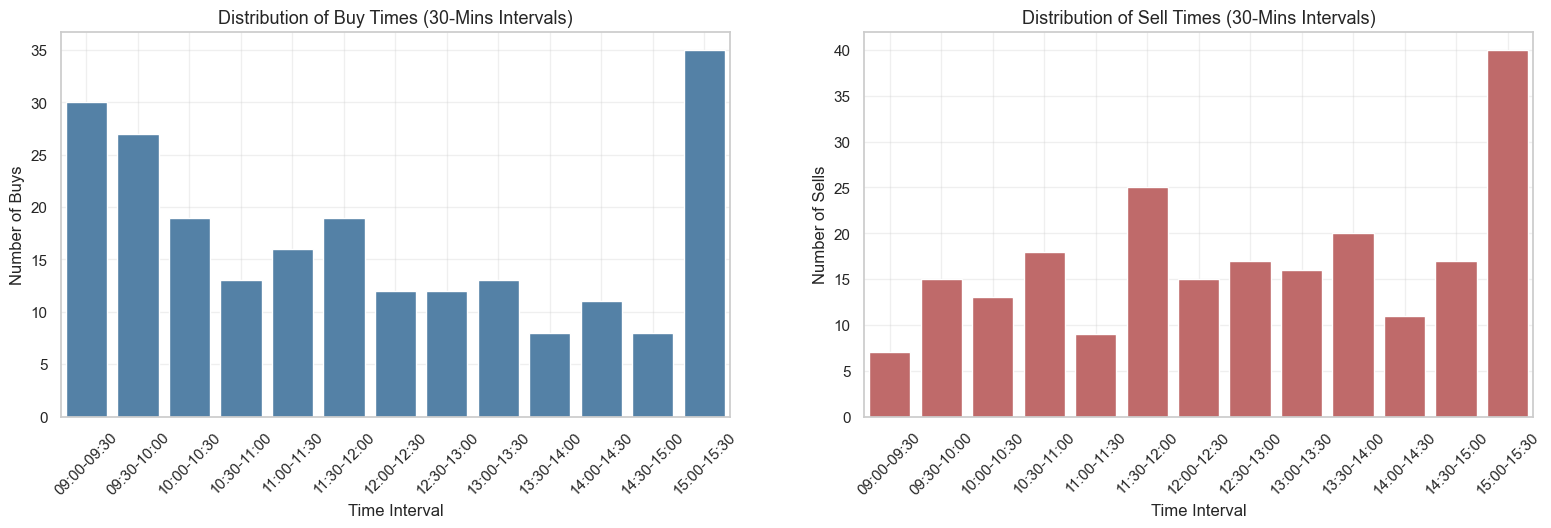

In [1748]:
fig, axes = plt.subplots(1, 2, figsize=(19, 5))
sns.set(style='whitegrid')

# Buy Time - ordered by time interval
axes[0].set_title("Distribution of Buy Times (30-Mins Intervals)", fontsize=13)
buy_time_data = pnl['Buy Interval'].value_counts().sort_index()
sns.barplot(x=buy_time_data.index, y=buy_time_data.values, ax=axes[0], color='steelblue')
axes[0].set_xlabel("Time Interval")
axes[0].set_ylabel("Number of Buys")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

# Sell Time - ordered by time interval
axes[1].set_title("Distribution of Sell Times (30-Mins Intervals)", fontsize=13)
sell_time_data = pnl['Sell Interval'].value_counts().sort_index()
sns.barplot(x=sell_time_data.index, y=sell_time_data.values, ax=axes[1], color='indianred')
axes[1].set_xlabel("Time Interval")
axes[1].set_ylabel("Number of Sells")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

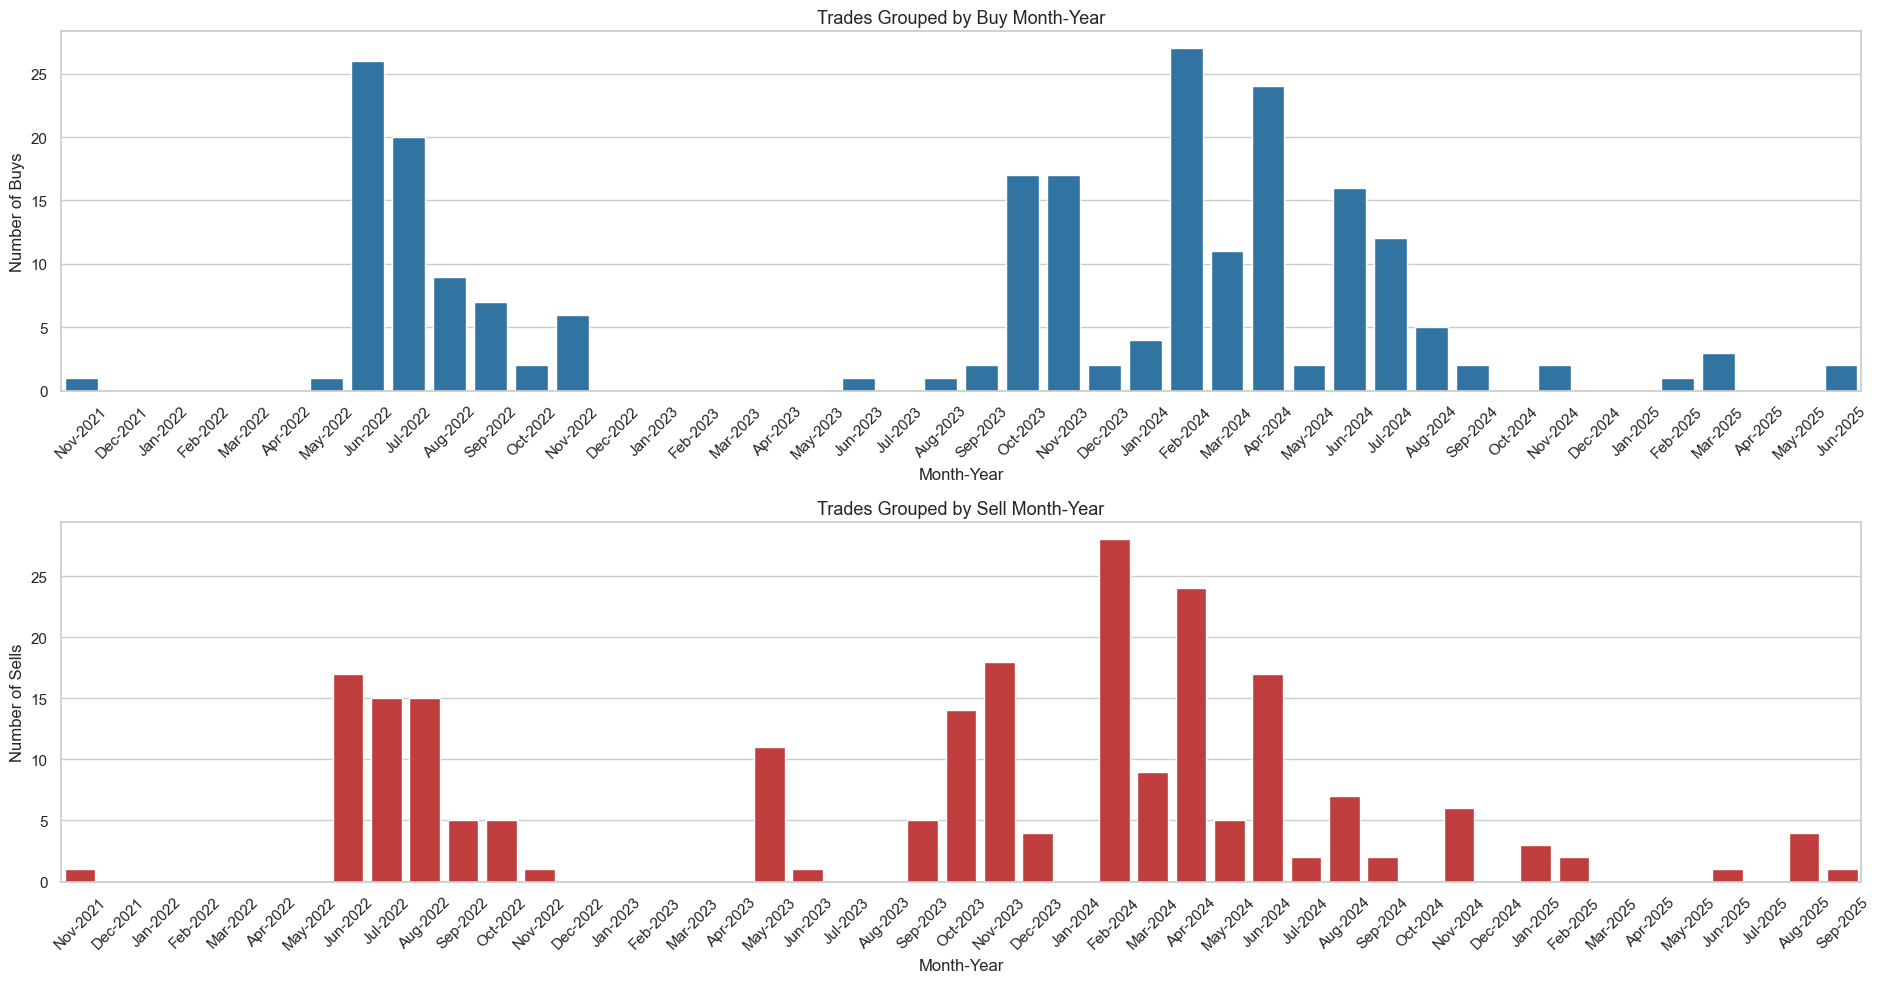

In [1749]:
fig, axes = plt.subplots(2, 1, figsize=(19, 10))
sns.set(style='whitegrid')

# Buy Month-Year trades with all months filled
axes[0].set_title("Trades Grouped by Buy Month-Year", fontsize=13)
pnl['Buy Month-Year'] = pnl['Buy Month'] + '-' + pnl['Buy Year'].astype(str)
min_date = pd.to_datetime(pnl['Buy Month-Year'], format='%b-%Y').min()
max_date = pd.to_datetime(pnl['Buy Month-Year'], format='%b-%Y').max()
all_months_buy = pd.date_range(start=min_date, end=max_date, freq='MS').strftime('%b-%Y')
buy_month_year_data = pnl['Buy Month-Year'].value_counts().reindex(all_months_buy, fill_value=0)
sns.barplot(x=buy_month_year_data.index, y=buy_month_year_data.values, ax=axes[0], color='#1f77b4')
axes[0].set_xlabel("Month-Year")
axes[0].set_ylabel("Number of Buys")
axes[0].tick_params(axis='x', rotation=45)

# Sell Month-Year trades with all months filled
axes[1].set_title("Trades Grouped by Sell Month-Year", fontsize=13)
pnl['Sell Month-Year'] = pnl['Sell Month'] + '-' + pnl['Sell Year'].astype(str)
min_date = pd.to_datetime(pnl['Sell Month-Year'], format='%b-%Y').min()
max_date = pd.to_datetime(pnl['Sell Month-Year'], format='%b-%Y').max()
all_months_sell = pd.date_range(start=min_date, end=max_date, freq='MS').strftime('%b-%Y')
sell_month_year_data = pnl['Sell Month-Year'].value_counts().reindex(all_months_sell, fill_value=0)
sns.barplot(x=sell_month_year_data.index, y=sell_month_year_data.values, ax=axes[1], color='#d62728')
axes[1].set_xlabel("Month-Year")
axes[1].set_ylabel("Number of Sells")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

These Plots tells us that the user had buy the most number of the stocks in the first hour of the day and sell stocks in the last hour of the day while also says that the user was trading from the Nov,21 but were mostly active between the June,22 to Sept,22 and Oct,23 to July,24 telling that he is not focused properly or gets unactive after huge losses and also he had taken some gaps between the months were he was completely unactive.

2. Bivariate Analysis

Now, let's do the bivariate analysis. Starting with the plots between the Numerical vs Numerical features

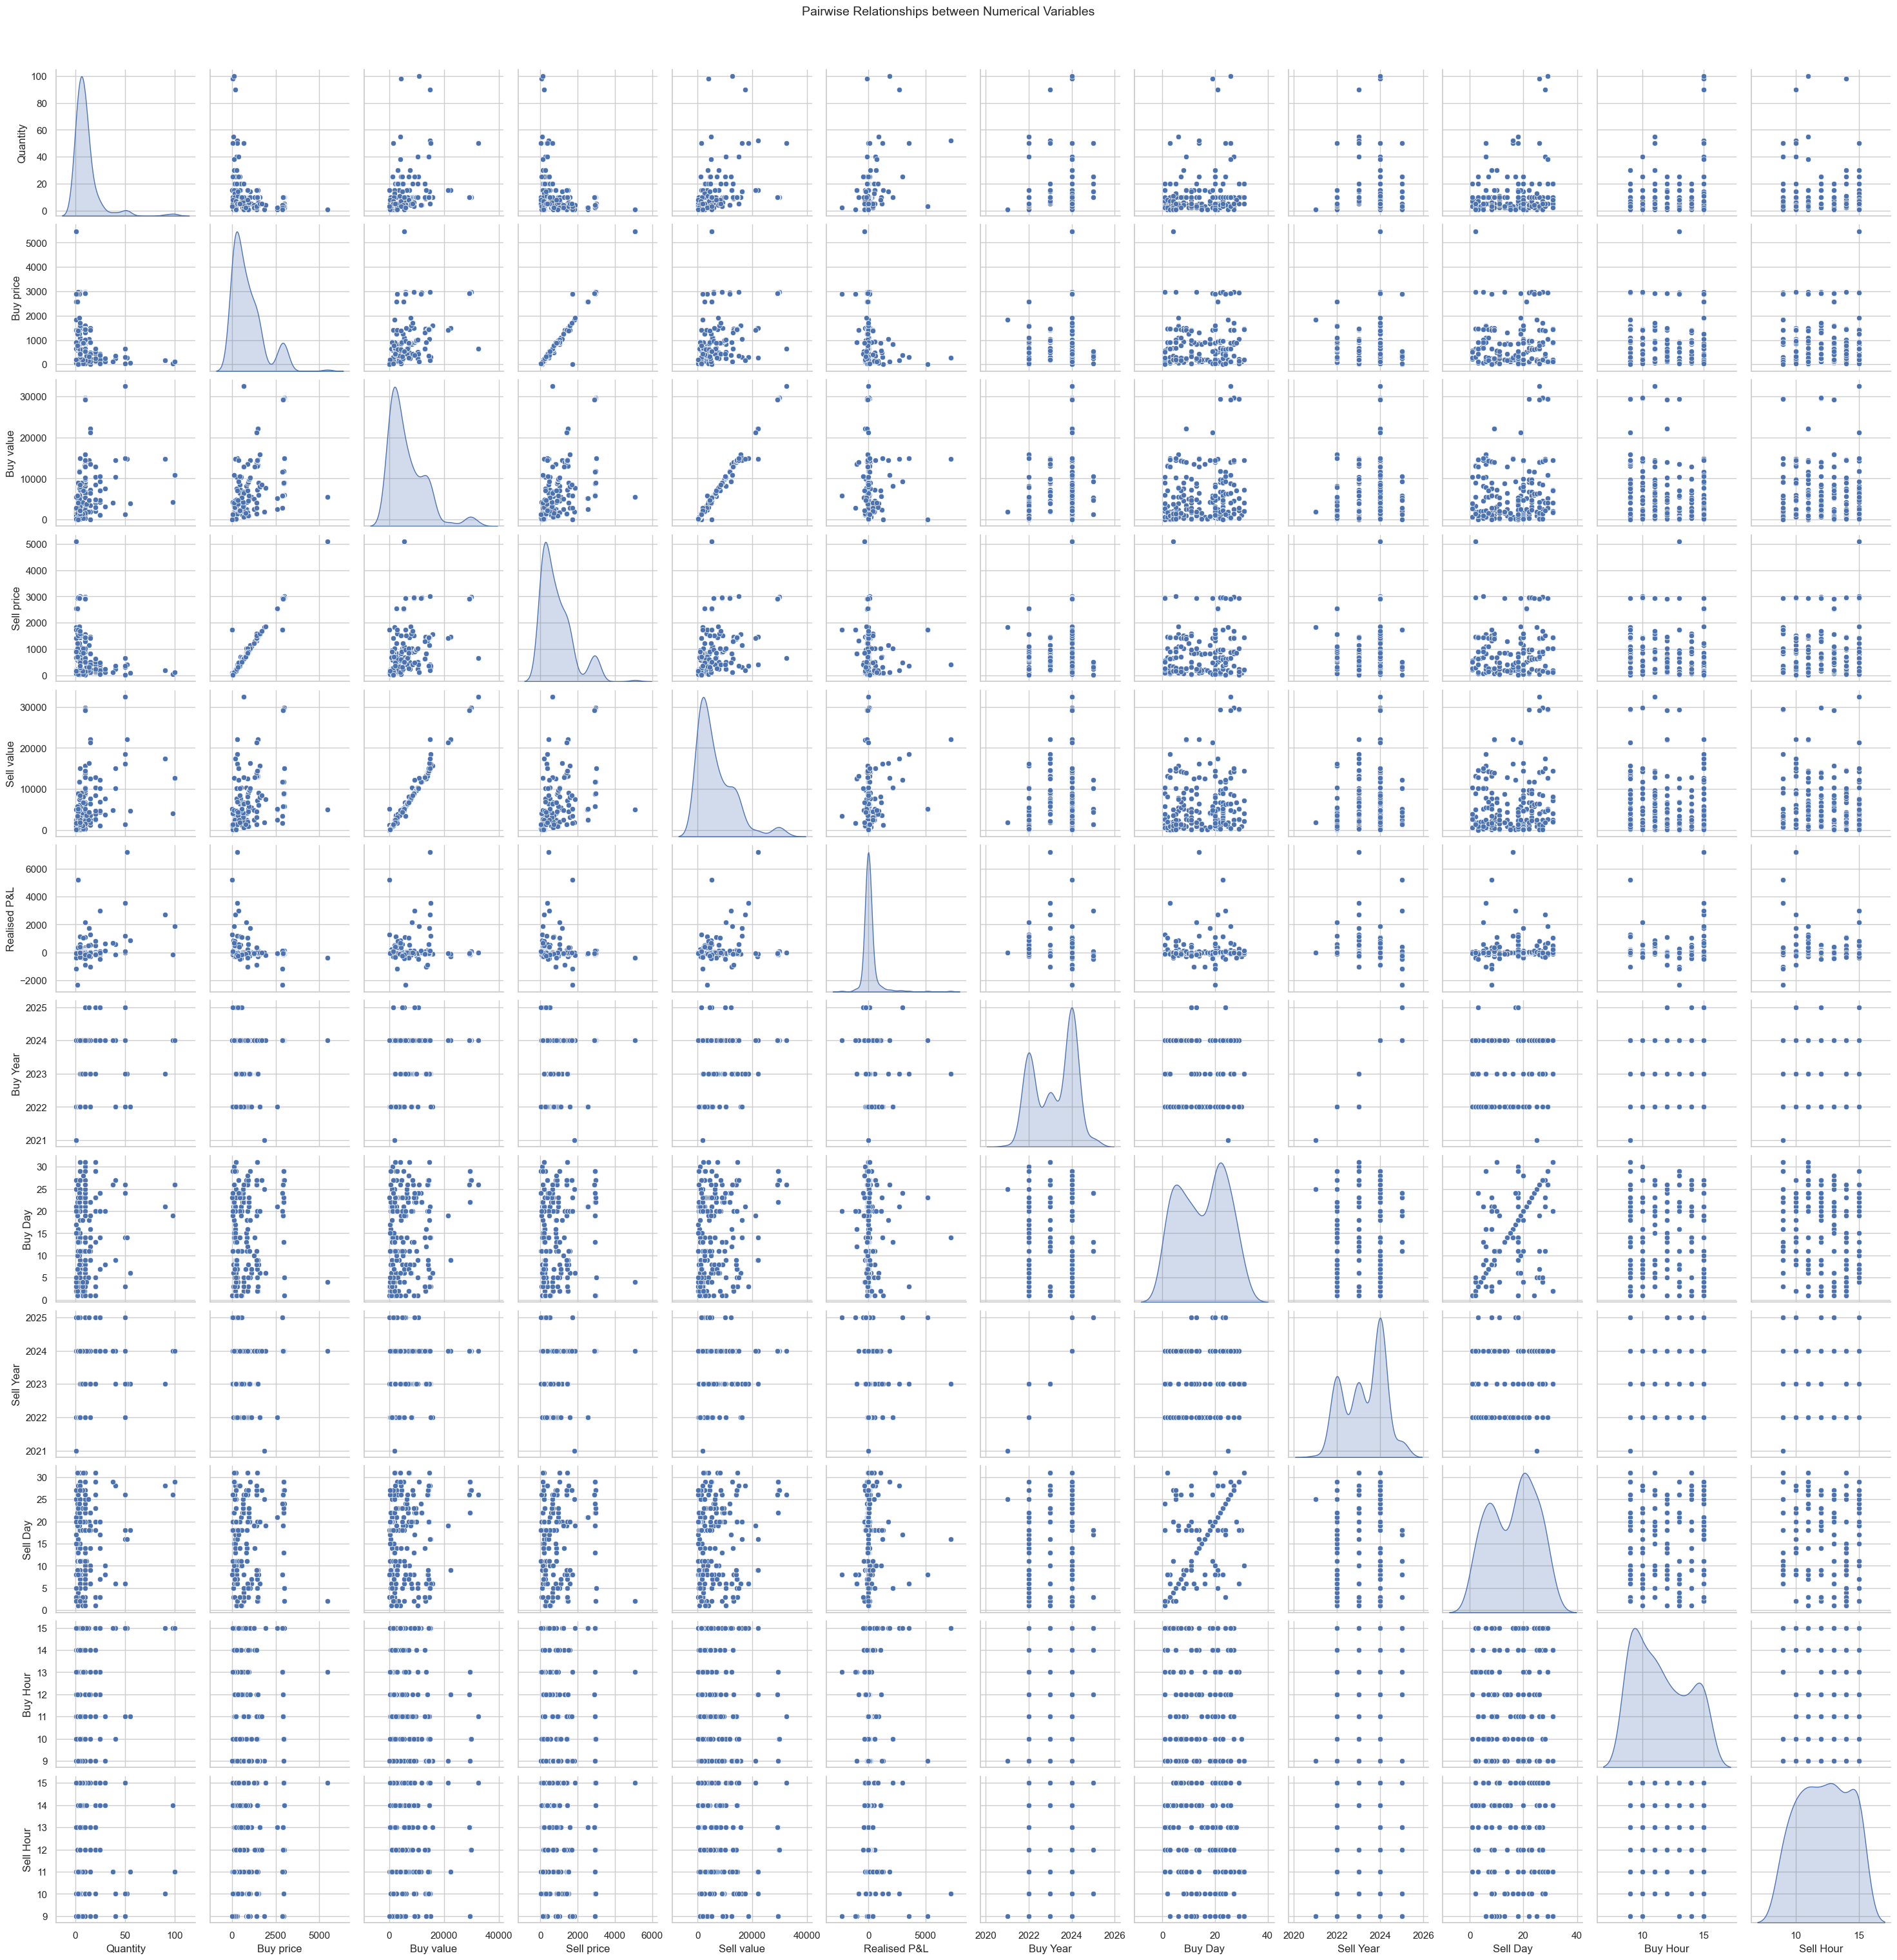

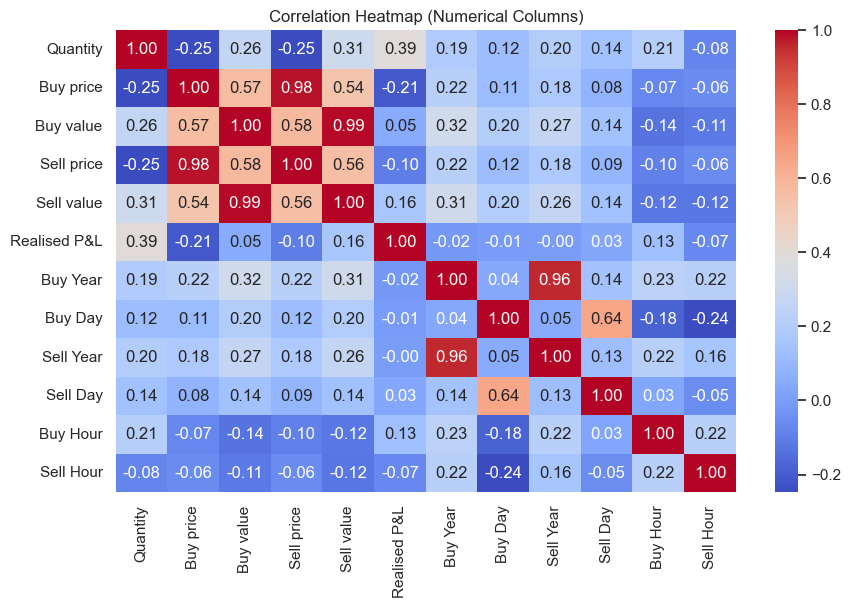

In [1750]:
# Pairplot for all numerical features
sns.pairplot(pnl[numerical_cols], diag_kind='kde', corner=False)
plt.suptitle("Pairwise Relationships between Numerical Variables", y=1.02, fontsize=14)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pnl[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Columns)")
plt.show()

---------Plots between Numerical vs Categorical features

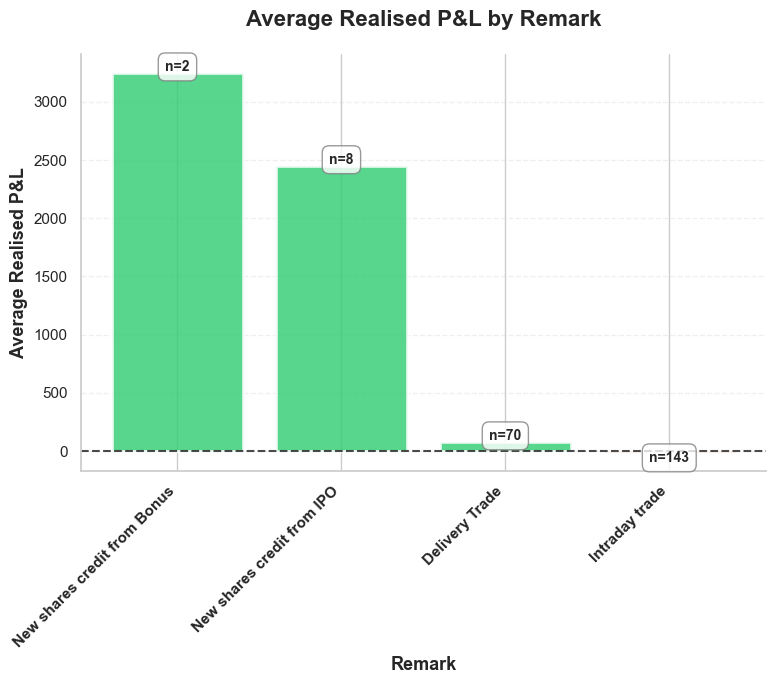

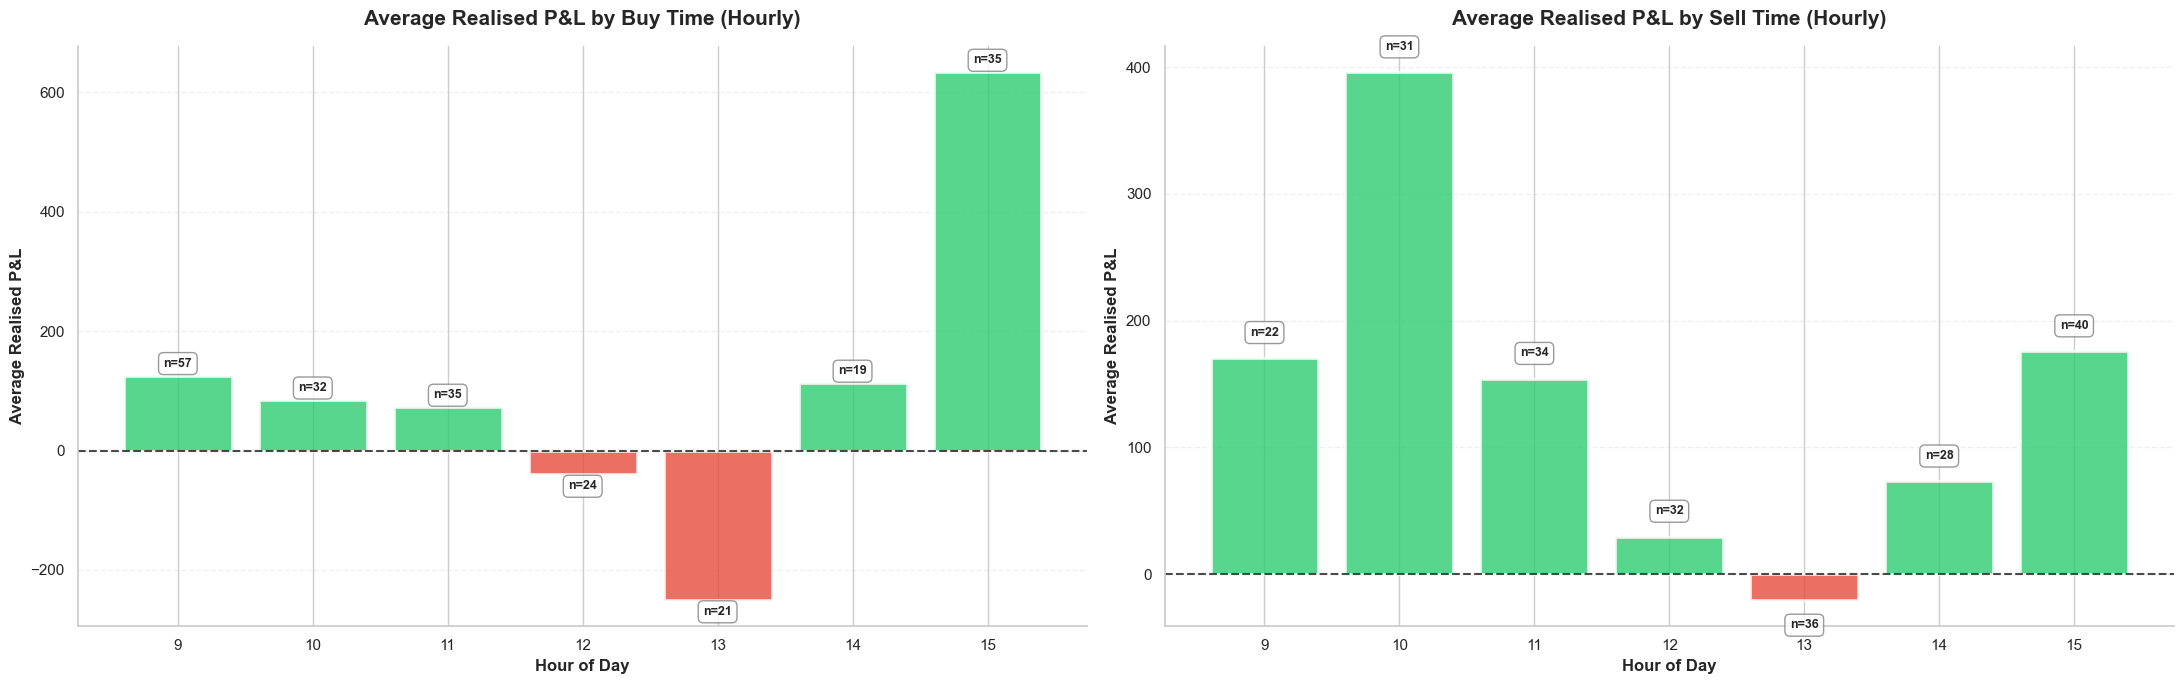

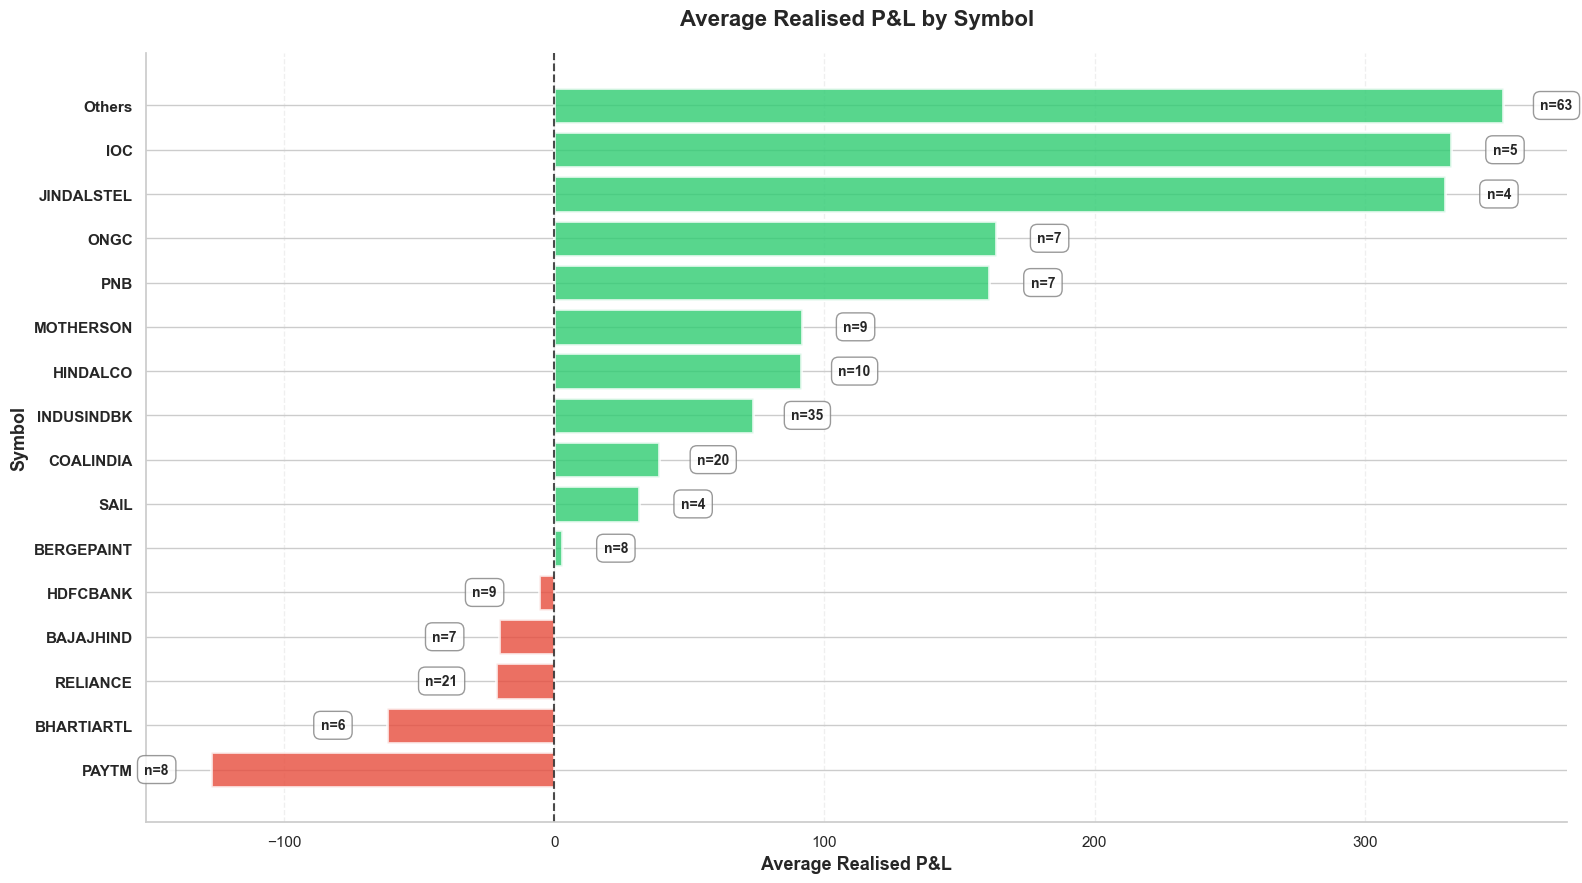

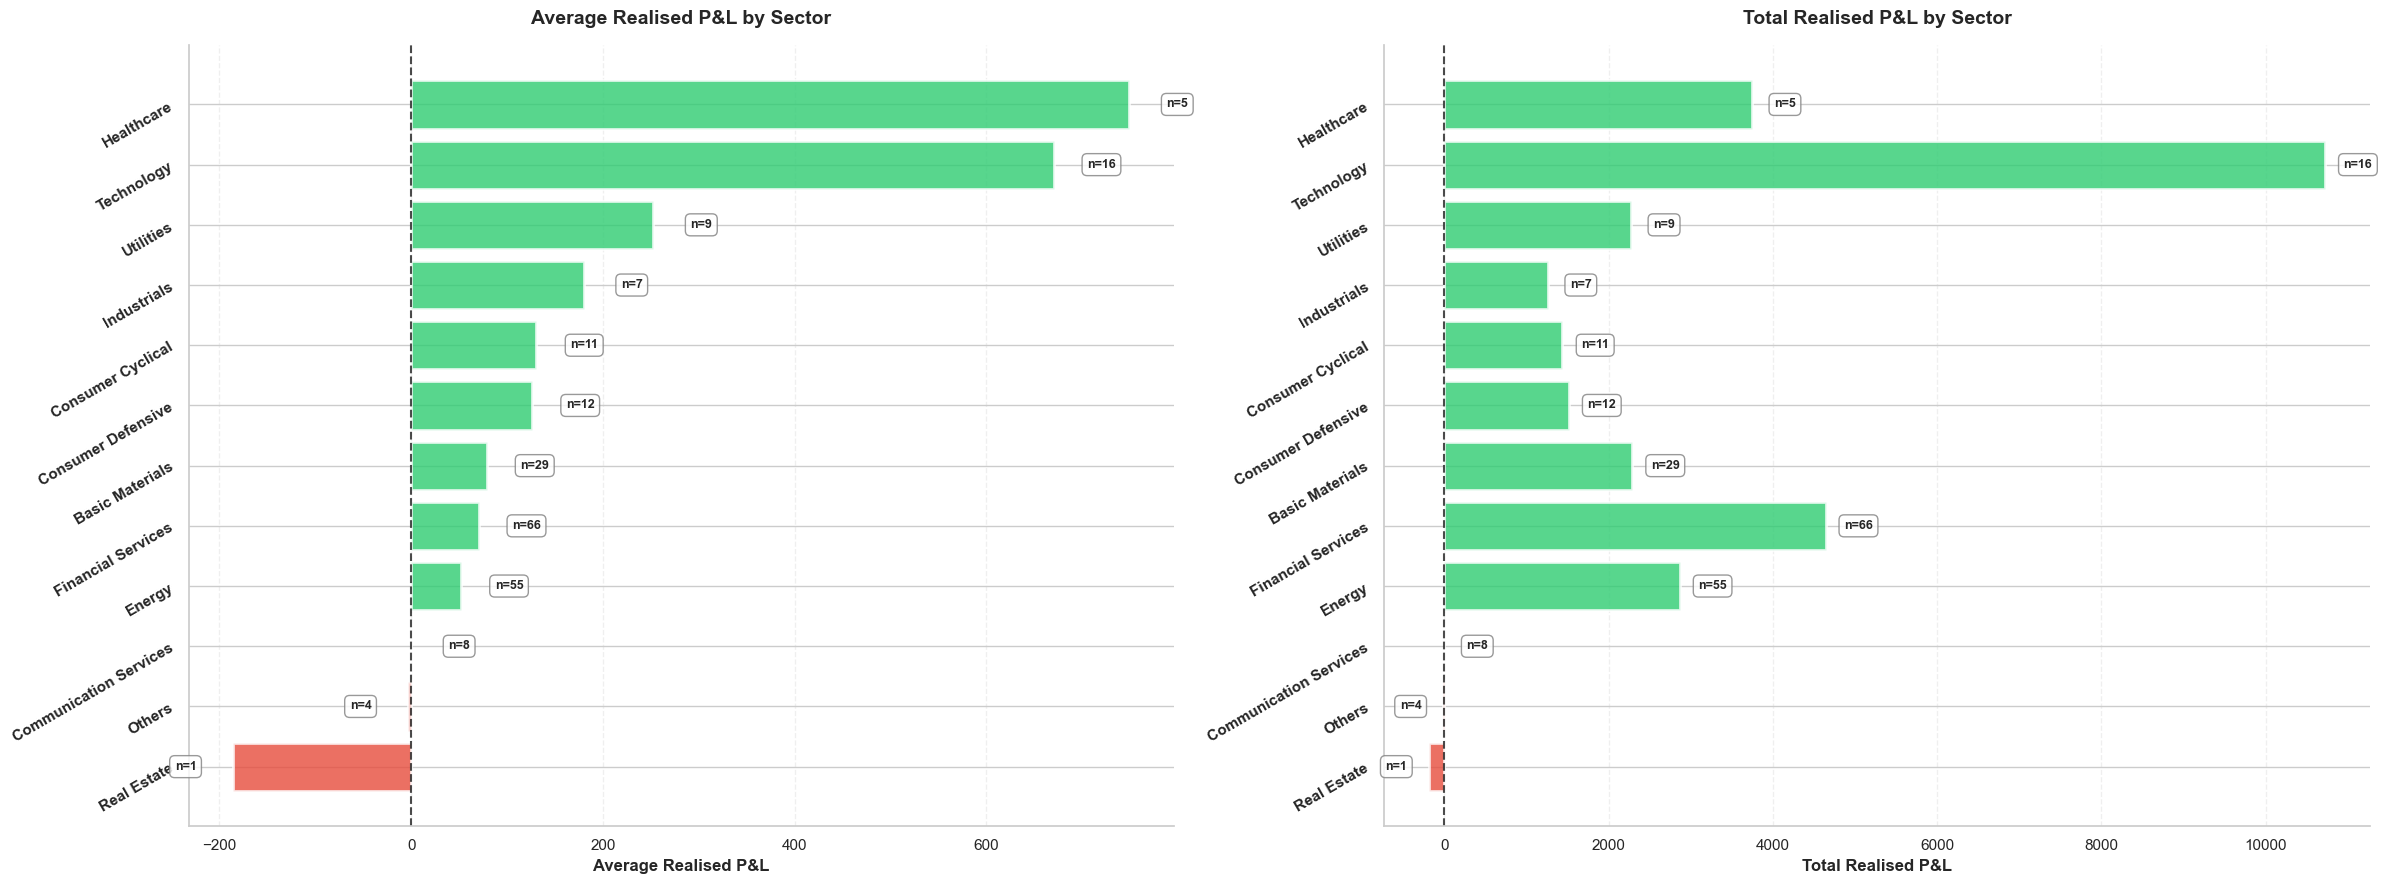

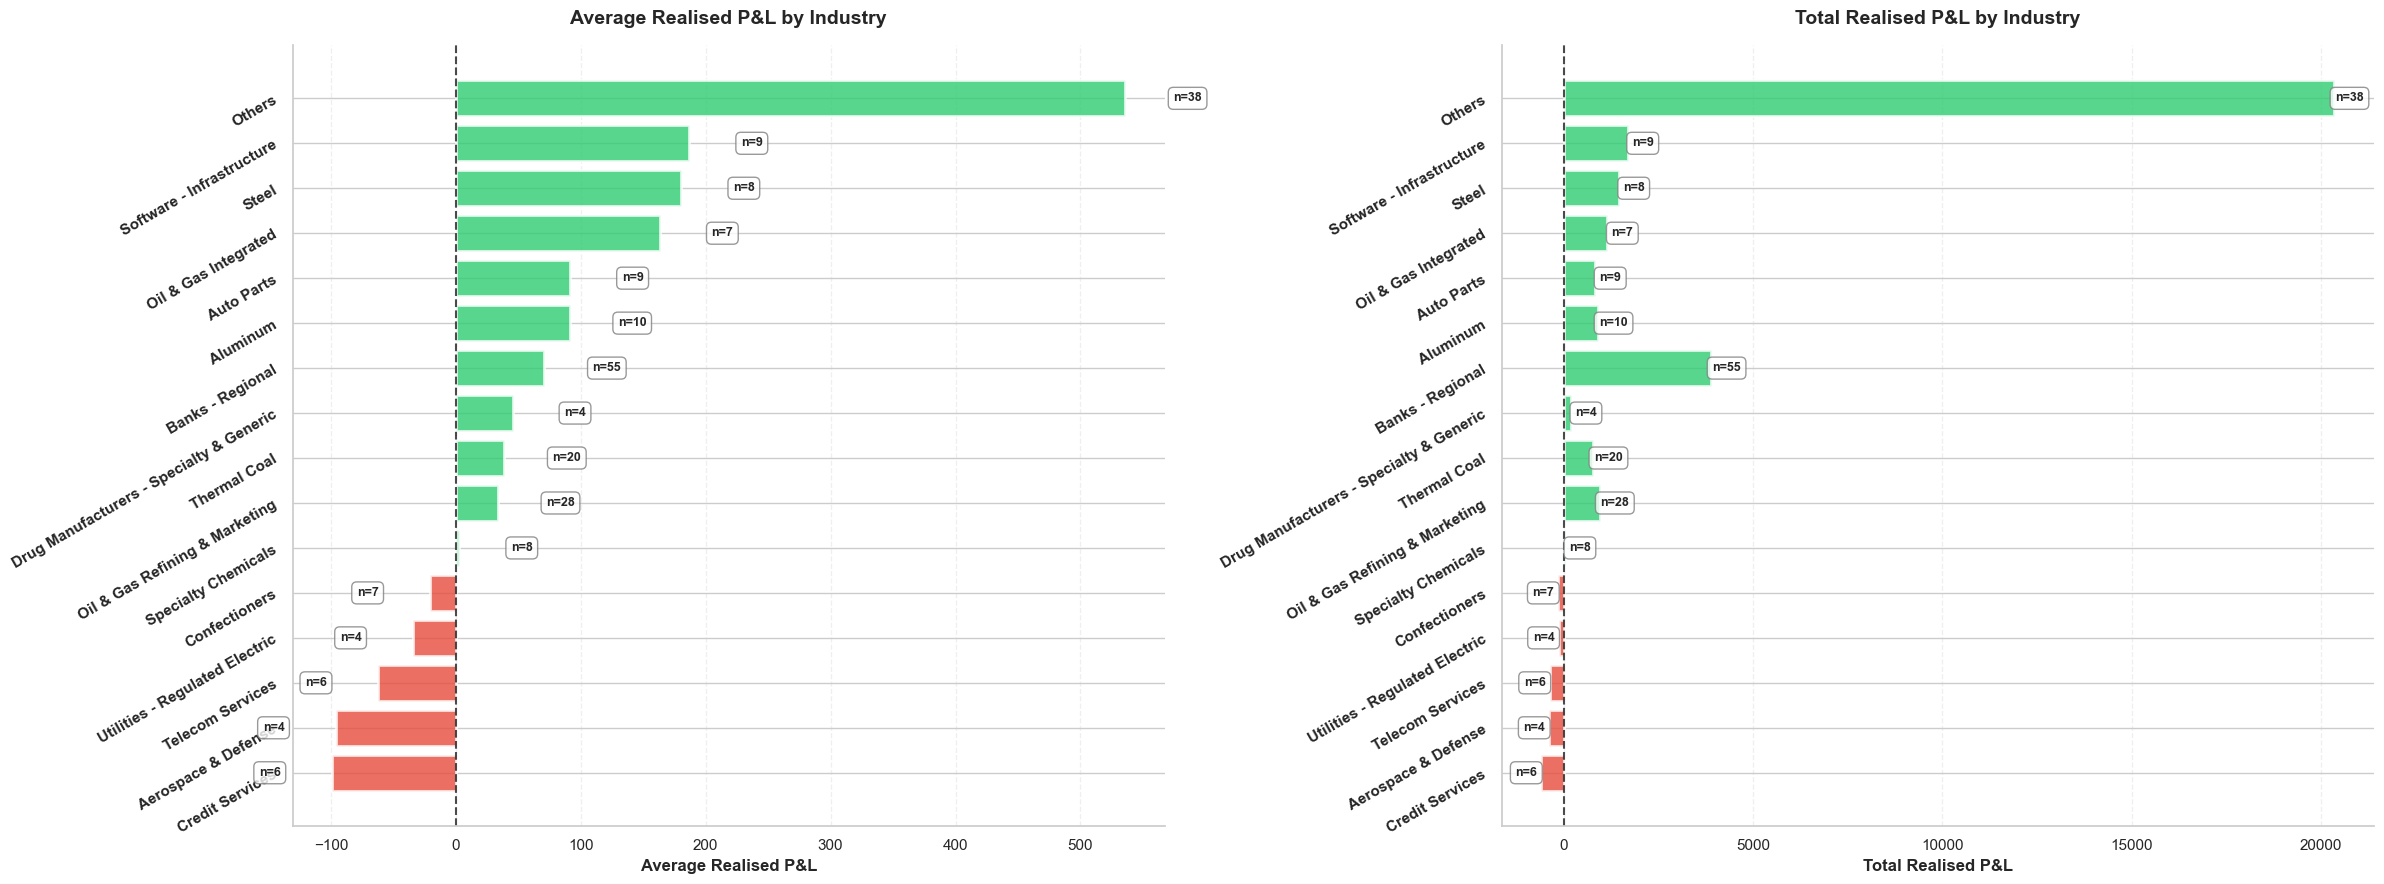

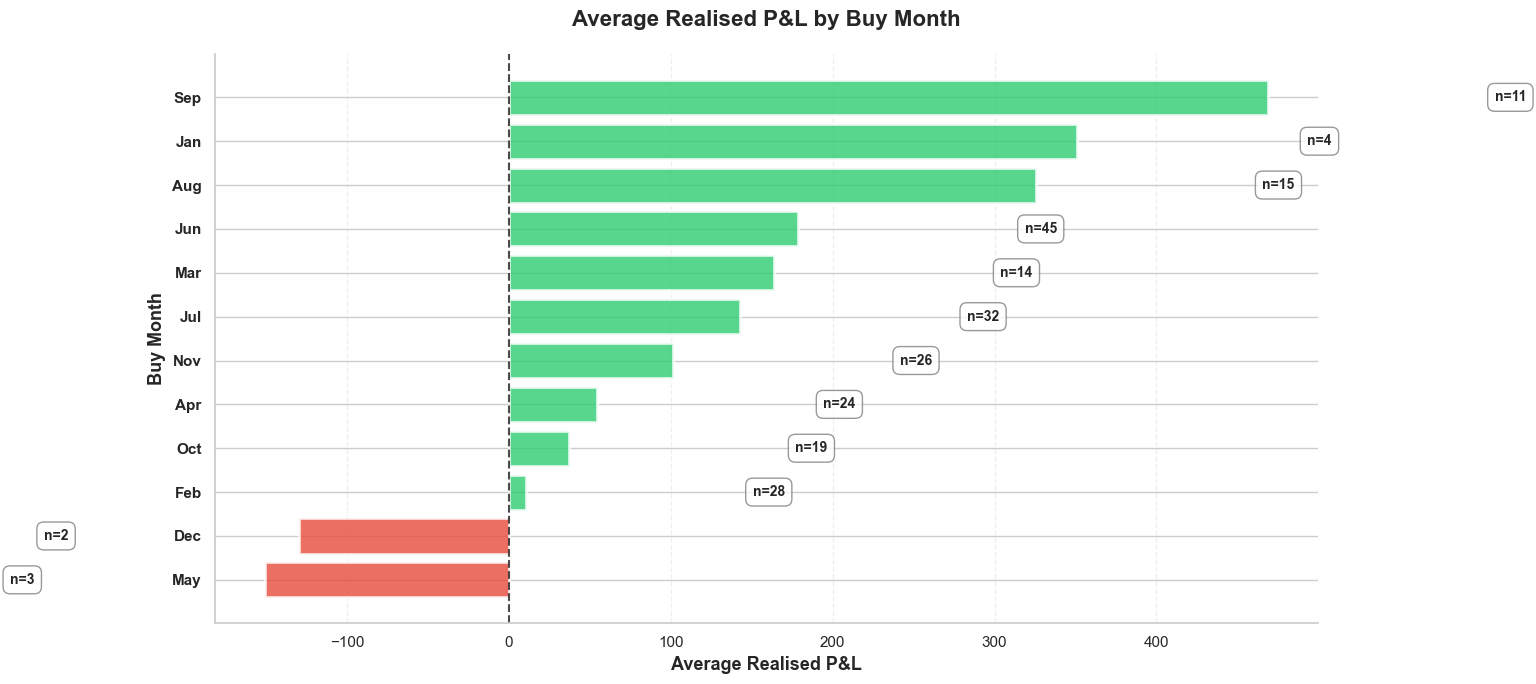

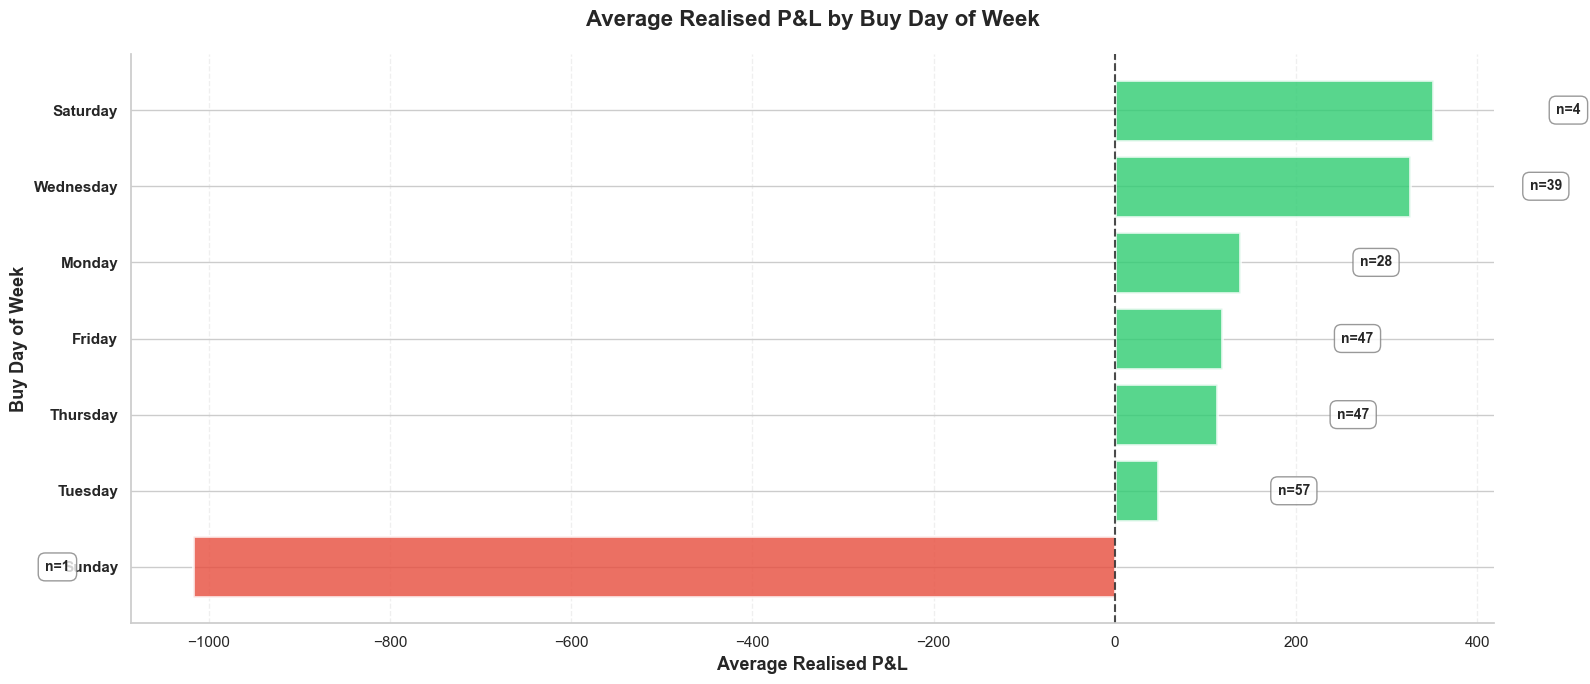

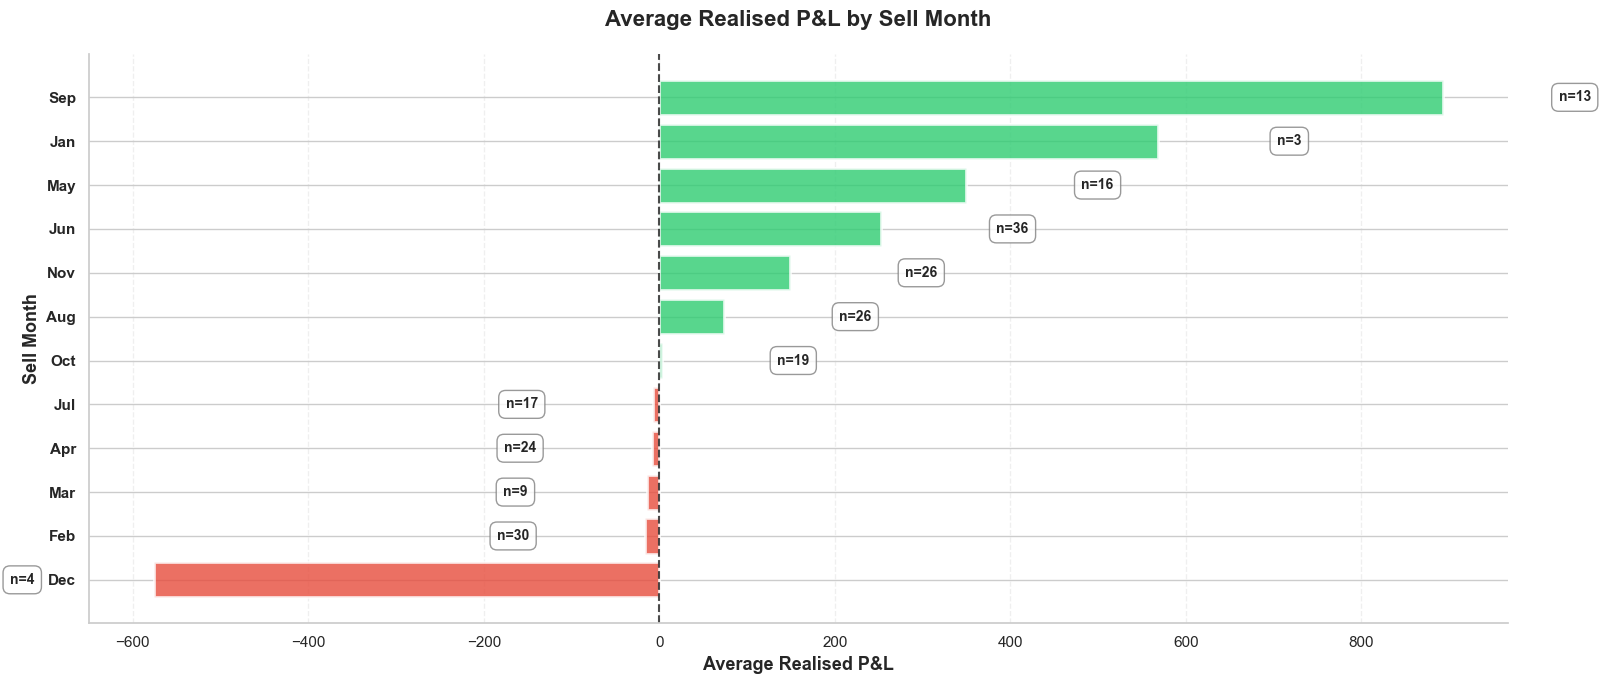

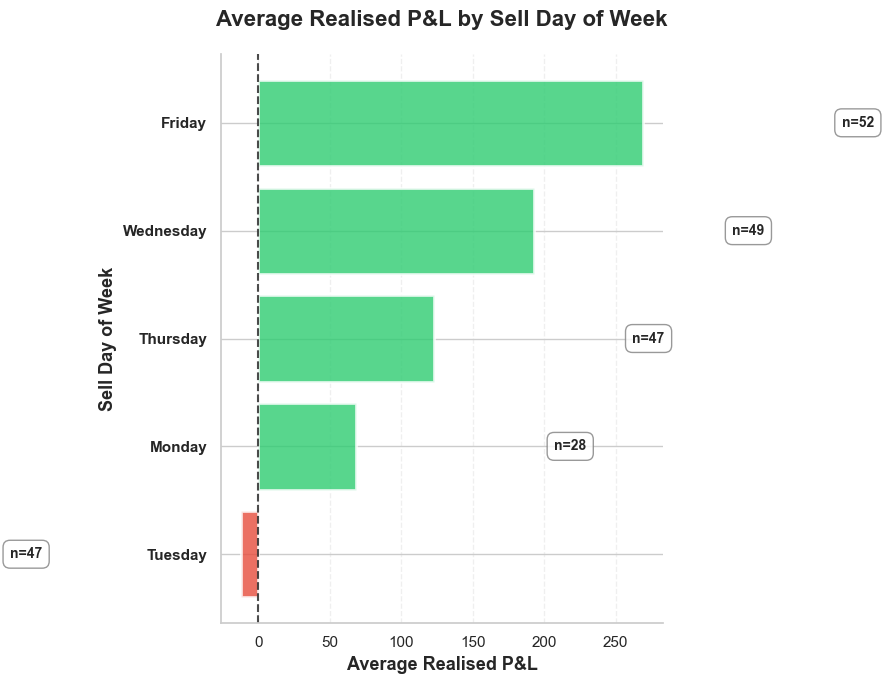

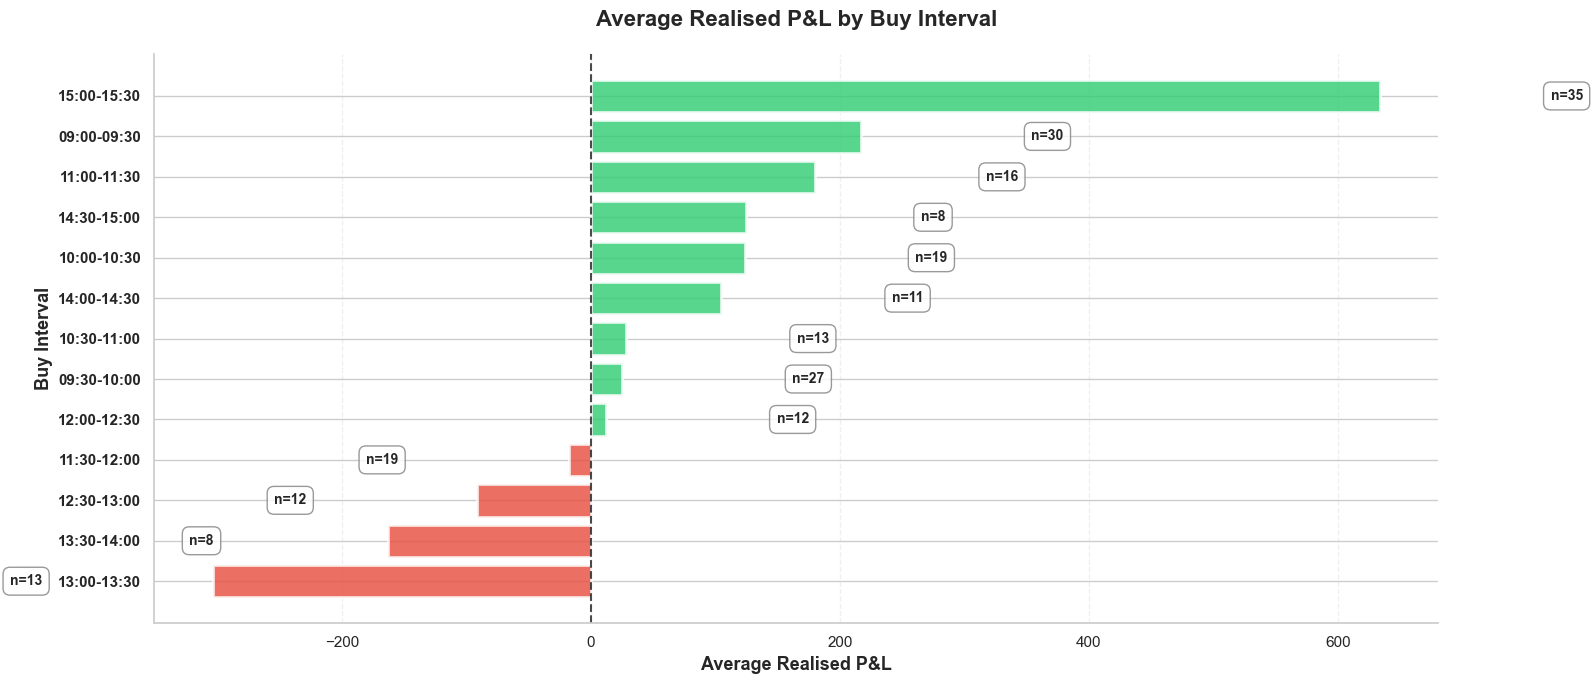

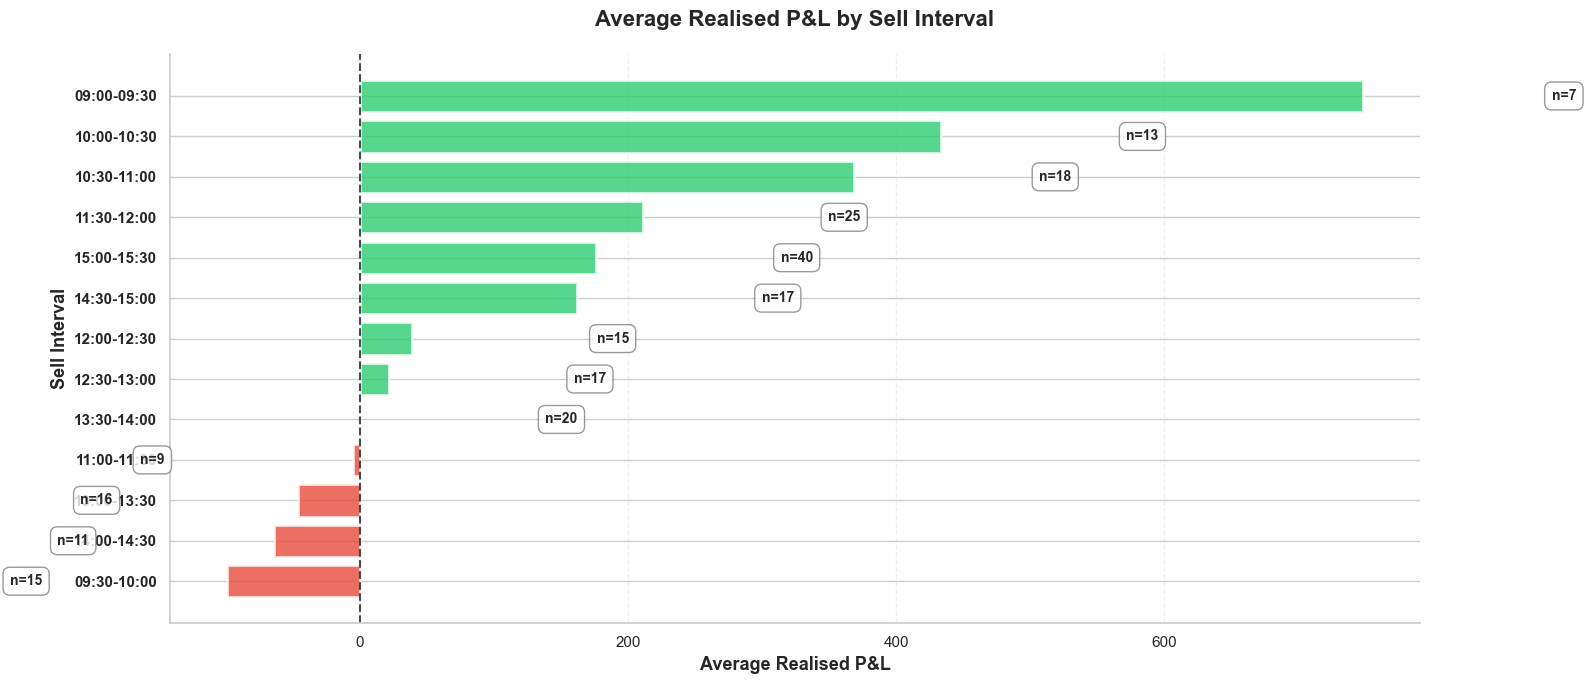

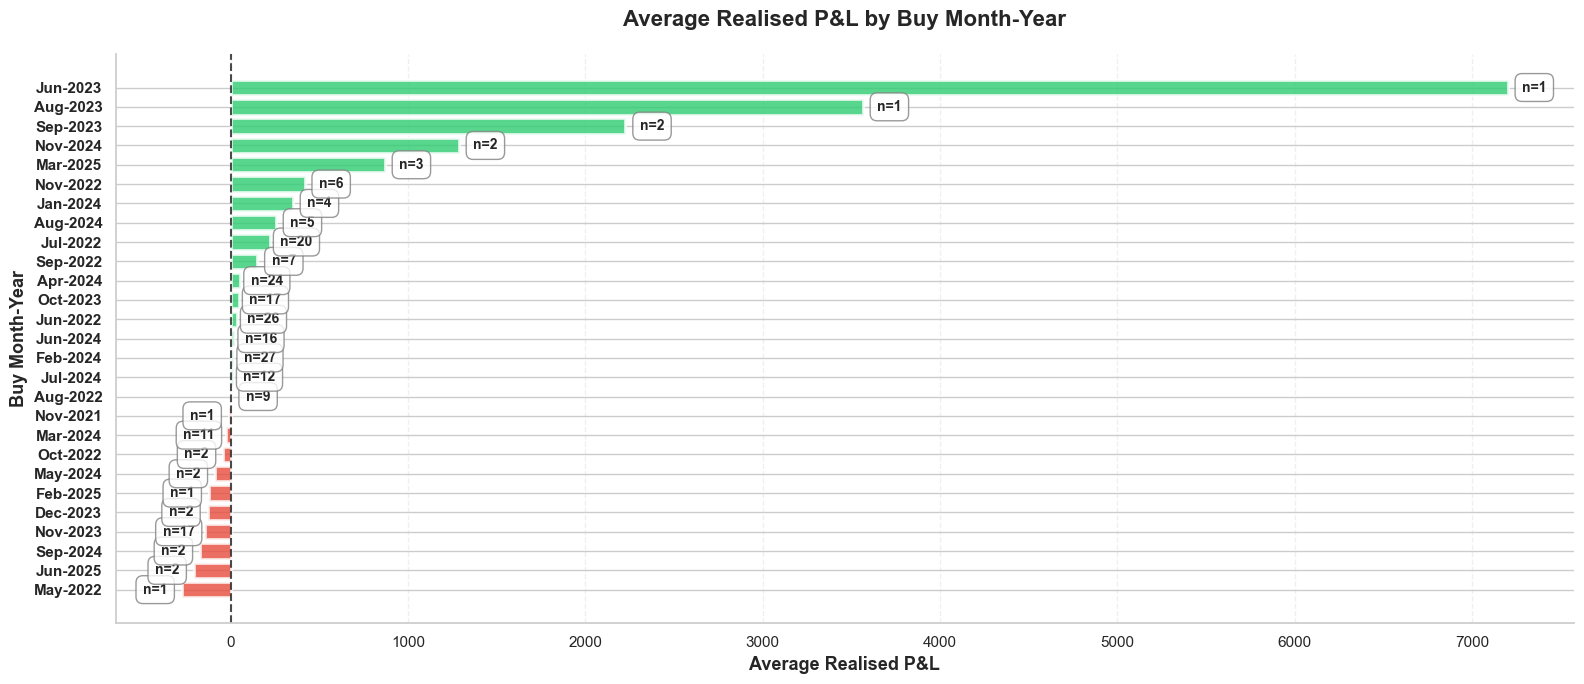

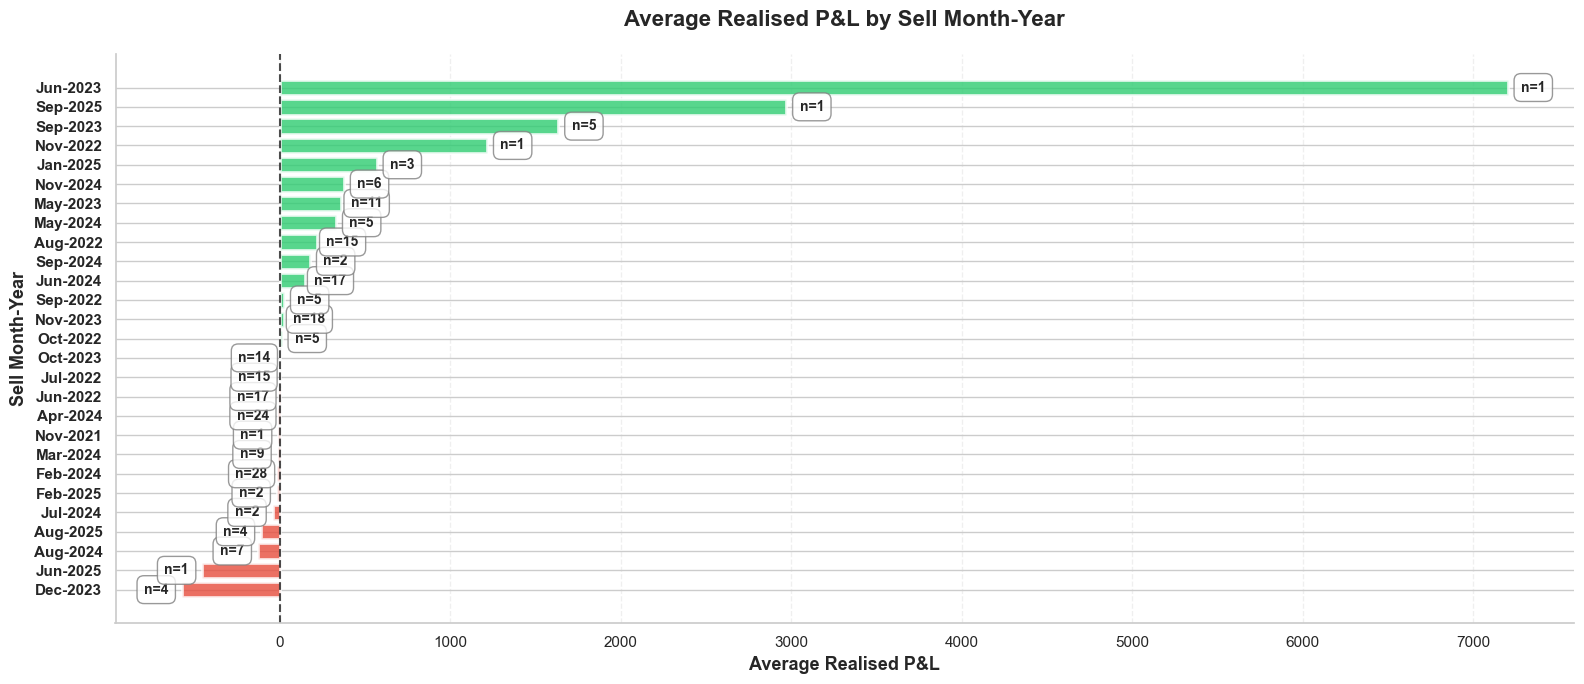

In [1751]:
categorical_cols = pnl.select_dtypes(include=['object']).columns
categorical_cols_drop = categorical_cols.drop(['ISIN', 'Stock name', 'Buy date', 'Sell date'])
target = 'Realised P&L'

if target not in pnl.columns:
    print("Target column 'Realised P&L' not found — skipping plots.")
else:
    for col in categorical_cols_drop:
        n_unique = pnl[col].nunique()
        
        if col in ['Buy Time', 'Sell Time']:
            if col == 'Buy Time':
                fig, axes = plt.subplots(1, 2, figsize=(22, 7))
                
                for idx, time_col in enumerate(['Buy Time', 'Sell Time']):
                    pnl_time = pnl.copy()
                    pnl_time[f'{time_col}_Hour'] = pd.to_datetime(pnl_time[time_col], 
                                                                   format='%H:%M:%S', errors='coerce').dt.hour
                    
                    hourly_data = pnl_time.groupby(f'{time_col}_Hour')[target].agg(['mean', 'count']).reset_index()
                    hourly_data = hourly_data.sort_values(f'{time_col}_Hour')
                    
                    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in hourly_data['mean']]
                    
                    axes[idx].bar(hourly_data[f'{time_col}_Hour'], hourly_data['mean'], 
                                 color=colors, alpha=0.8, edgecolor='white', linewidth=2)
                    axes[idx].set_title(f"Average {target} by {time_col} (Hourly)", 
                                       fontsize=15, fontweight='bold', pad=15)
                    axes[idx].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
                    axes[idx].set_ylabel(f'Average {target}', fontsize=12, fontweight='bold')
                    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
                    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
                    axes[idx].spines['top'].set_visible(False)
                    axes[idx].spines['right'].set_visible(False)
                    axes[idx].set_xticks(hourly_data[f'{time_col}_Hour'])
                    
                    for i, row in hourly_data.iterrows():
                        offset = 20 if row['mean'] > 0 else -20
                        axes[idx].text(row[f'{time_col}_Hour'], row['mean'] + offset, 
                                      f"n={int(row['count'])}", 
                                      ha='center', va='center', fontsize=9, fontweight='bold',
                                      bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                               edgecolor='gray', alpha=0.8))
                
                plt.tight_layout()
                plt.show()
        
        elif col == 'Symbol':
            fig, ax = plt.subplots(figsize=(16, 9))
            stats = pnl.groupby(col)[target].agg(['mean', 'count']).reset_index()
            stats = stats.sort_values('mean', ascending=True)
            
            colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in stats['mean']]
            
            bars = ax.barh(range(len(stats)), stats['mean'], color=colors, alpha=0.8, 
                          edgecolor='white', linewidth=2)
            
            ax.set_yticks(range(len(stats)))
            ax.set_yticklabels(stats[col], fontsize=11, fontweight='bold')
            ax.set_title(f'Average {target} by {col}', fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel(f'Average {target}', fontsize=13, fontweight='bold')
            ax.set_ylabel(col, fontsize=13, fontweight='bold')
            ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, (idx, row) in enumerate(stats.iterrows()):
                offset = 20 if row['mean'] > 0 else -20
                ax.text(row['mean'] + offset, i, f"n={int(row['count'])}", 
                       va='center', ha='center', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                                edgecolor='gray', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
        
        elif col in ['Sector', 'Industry']:
            fig, axes = plt.subplots(1, 2, figsize=(24, 9))
            
            stats = pnl.groupby(col)[target].agg(['mean', 'sum', 'count']).reset_index()
            stats = stats.sort_values('mean', ascending=True)
            
            colors_mean = ['#2ecc71' if x > 0 else '#e74c3c' for x in stats['mean']]
            bars0 = axes[0].barh(range(len(stats)), stats['mean'], color=colors_mean, 
                                alpha=0.8, edgecolor='white', linewidth=2)
            
            axes[0].set_yticks(range(len(stats)))
            axes[0].set_yticklabels(stats[col], fontsize=11, fontweight='bold', rotation = 30)
            axes[0].set_title(f'Average {target} by {col}', fontsize=14, fontweight='bold', pad=15)
            axes[0].set_xlabel(f'Average {target}', fontsize=12, fontweight='bold')
            axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            axes[0].grid(axis='x', alpha=0.3, linestyle='--')
            axes[0].spines['top'].set_visible(False)
            axes[0].spines['right'].set_visible(False)
            
            for i, (idx, row) in enumerate(stats.iterrows()):
                offset = 50 if row['mean'] > 0 else -50
                axes[0].text(row['mean'] + offset, i, f"n={int(row['count'])}", 
                           va='center', ha='center', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                    edgecolor='gray', alpha=0.8))
            
            colors_total = ['#2ecc71' if x > 0 else '#e74c3c' for x in stats['sum']]
            bars1 = axes[1].barh(range(len(stats)), stats['sum'], color=colors_total, 
                                alpha=0.8, edgecolor='white', linewidth=2)
            
            axes[1].set_yticks(range(len(stats)))
            axes[1].set_yticklabels(stats[col], fontsize=11, fontweight='bold', rotation = 30)
            axes[1].set_title(f'Total {target} by {col}', fontsize=14, fontweight='bold', pad=15)
            axes[1].set_xlabel(f'Total {target}', fontsize=12, fontweight='bold')
            axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            axes[1].grid(axis='x', alpha=0.3, linestyle='--')
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            
            for i, (idx, row) in enumerate(stats.iterrows()):
                offset = 400 if row['sum'] > 0 else -400
                axes[1].text(row['sum'] + offset, i, f"n={int(row['count'])}", 
                           va='center', ha='center', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                    edgecolor='gray', alpha=0.8))
            
            plt.tight_layout()
            plt.show()

        elif col == 'Remark':
            fig, ax = plt.subplots(figsize=(8, 7))
            stats = pnl.groupby(col)[target].agg(['mean', 'count']).reset_index()
            stats = stats.sort_values('mean', ascending=False)
            
            colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in stats['mean']]
            
            bars = ax.bar(range(len(stats)), stats['mean'], color=colors, alpha=0.8, 
                         edgecolor='white', linewidth=2)
            
            ax.set_xticks(range(len(stats)))
            ax.set_xticklabels(stats[col], fontsize=11, fontweight='bold', rotation=45, ha='right')
            ax.set_title(f'Average {target} by {col}', fontsize=16, fontweight='bold', pad=20)
            ax.set_ylabel(f'Average {target}', fontsize=13, fontweight='bold')
            ax.set_xlabel(col, fontsize=13, fontweight='bold')
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, (idx, row) in enumerate(stats.iterrows()):
                offset = 50 if row['mean'] > 0 else -50
                ax.text(i, row['mean'] + offset, f"n={int(row['count'])}", 
                       ha='center', va='center', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                                edgecolor='gray', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
        
        else:
            fig, ax = plt.subplots(figsize=(16, 7))
            stats = pnl.groupby(col)[target].agg(['mean', 'count']).reset_index()
            stats = stats.sort_values('mean', ascending=True)
            
            colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in stats['mean']]
            
            bars = ax.barh(range(len(stats)), stats['mean'], color=colors, alpha=0.8, 
                          edgecolor='white', linewidth=2)
            
            ax.set_yticks(range(len(stats)))
            ax.set_yticklabels(stats[col], fontsize=11, fontweight='bold')
            ax.set_title(f'Average {target} by {col}', fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel(f'Average {target}', fontsize=13, fontweight='bold')
            ax.set_ylabel(col, fontsize=13, fontweight='bold')
            ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, (idx, row) in enumerate(stats.iterrows()):
                offset = 150 if row['mean'] > 0 else -150
                ax.text(row['mean'] + offset, i, f"n={int(row['count'])}", 
                       va='center', ha='center', fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                                edgecolor='gray', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            

-----------Plots between Categorical vs Categorical features

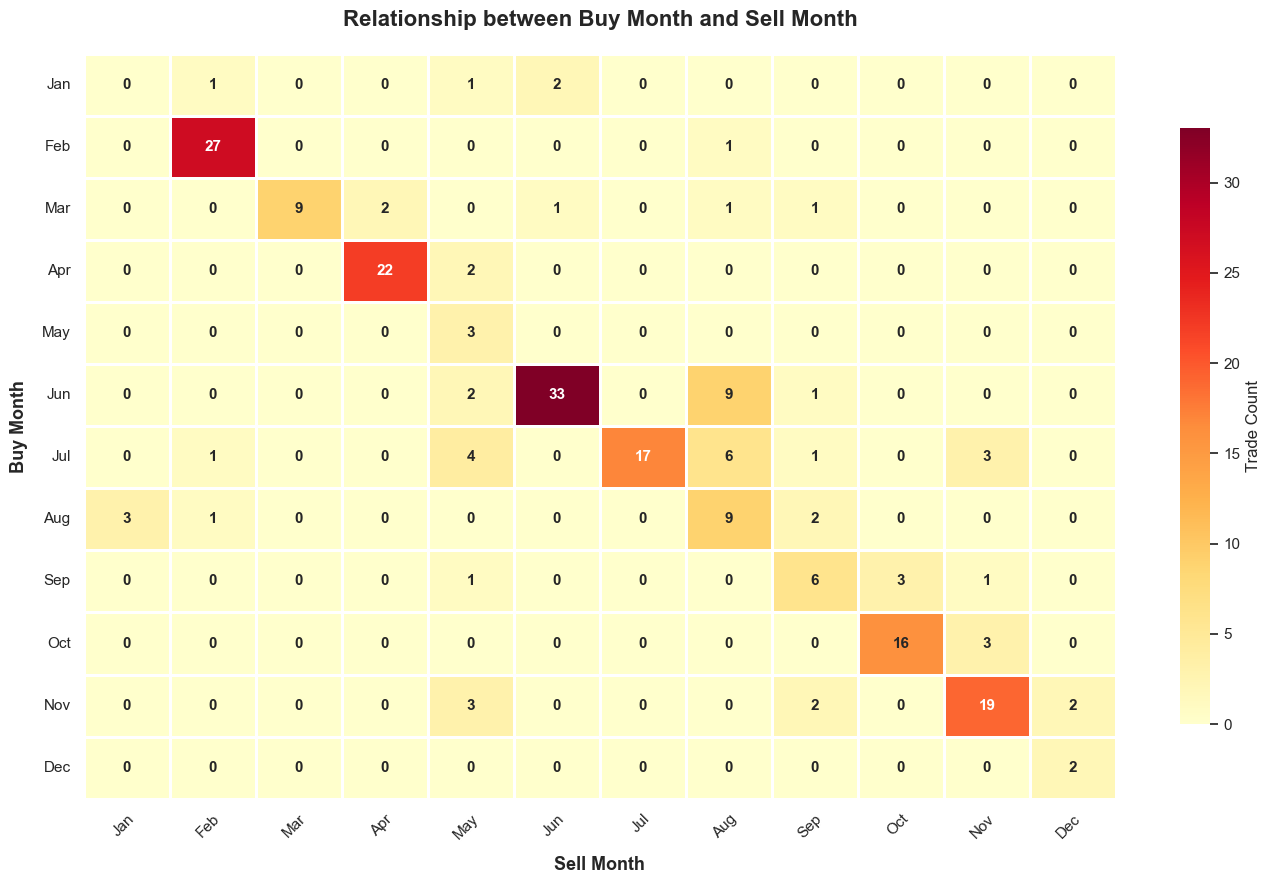

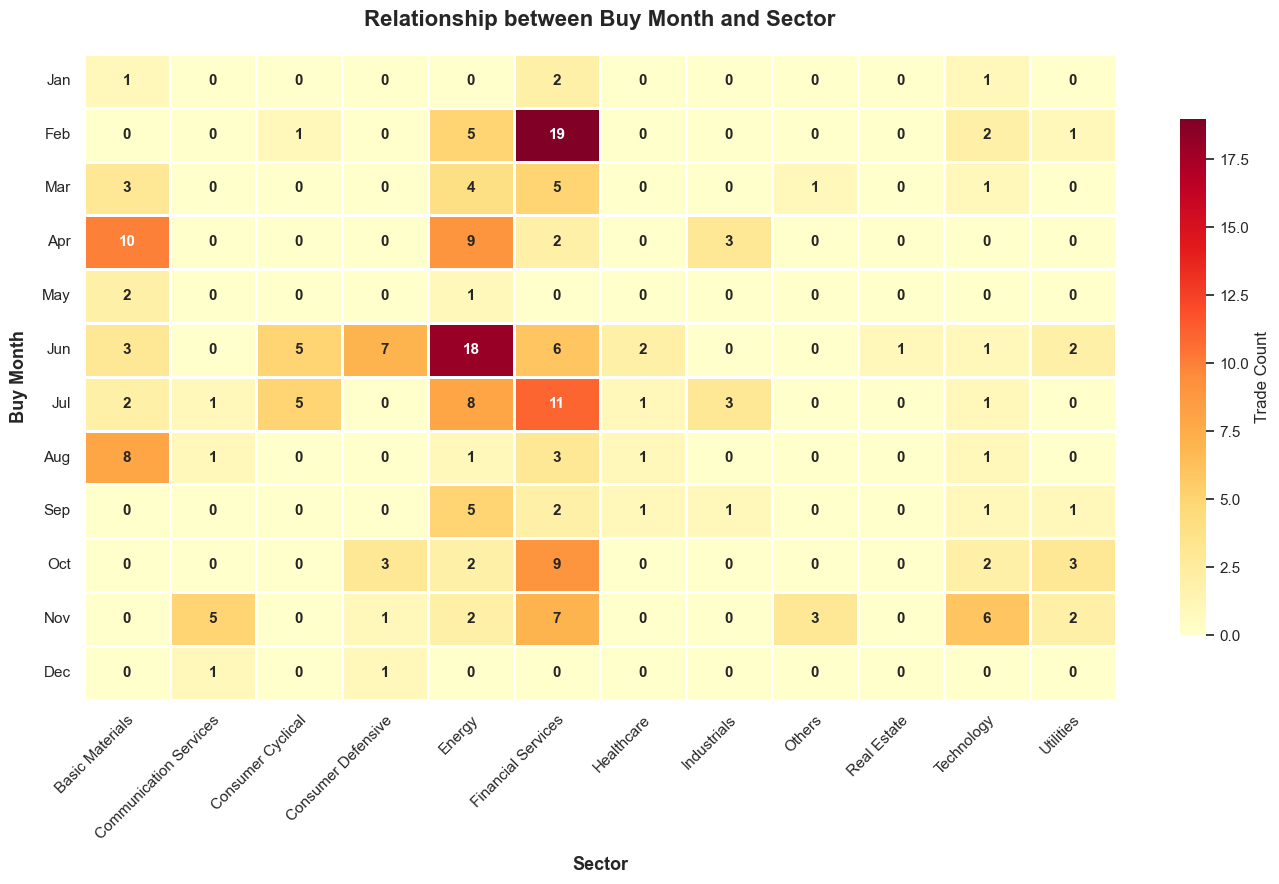

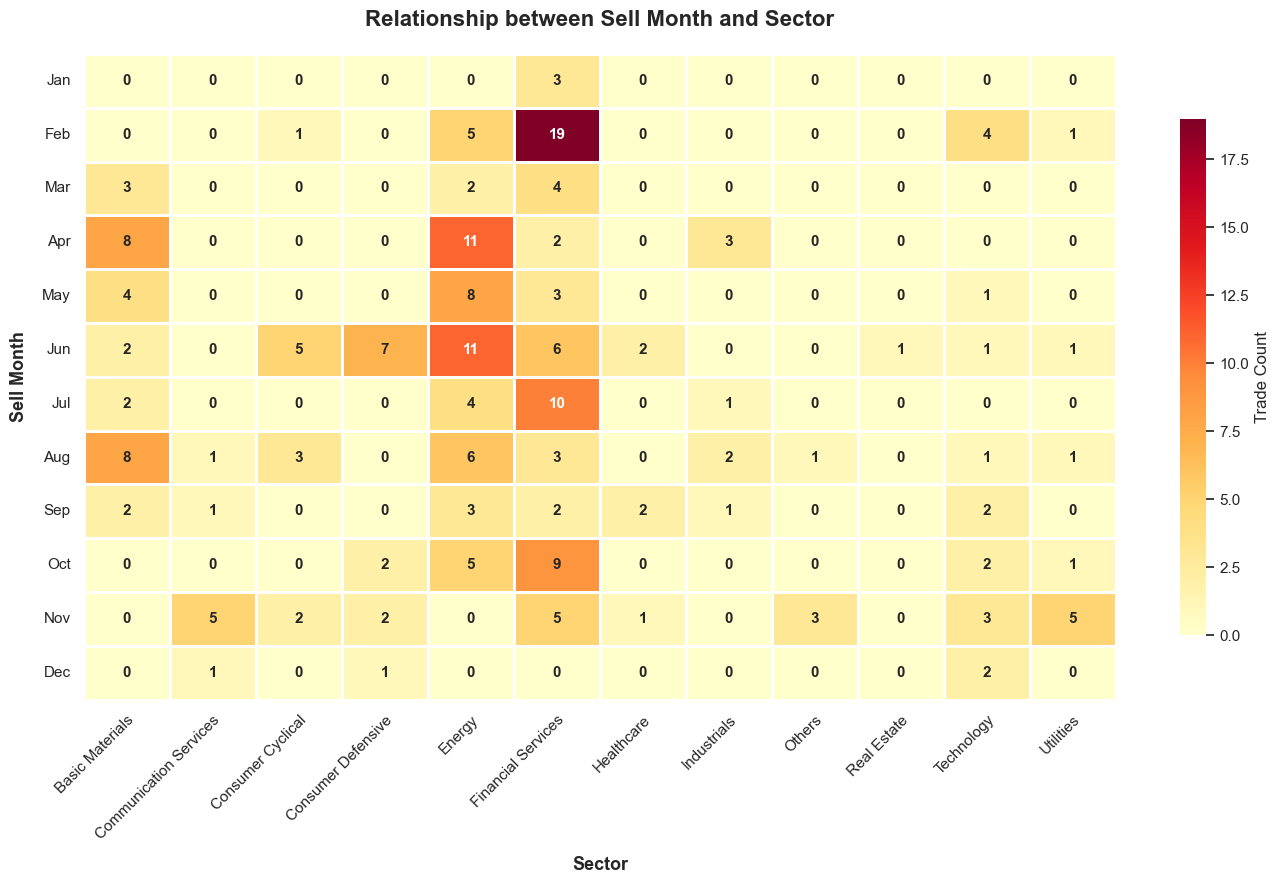

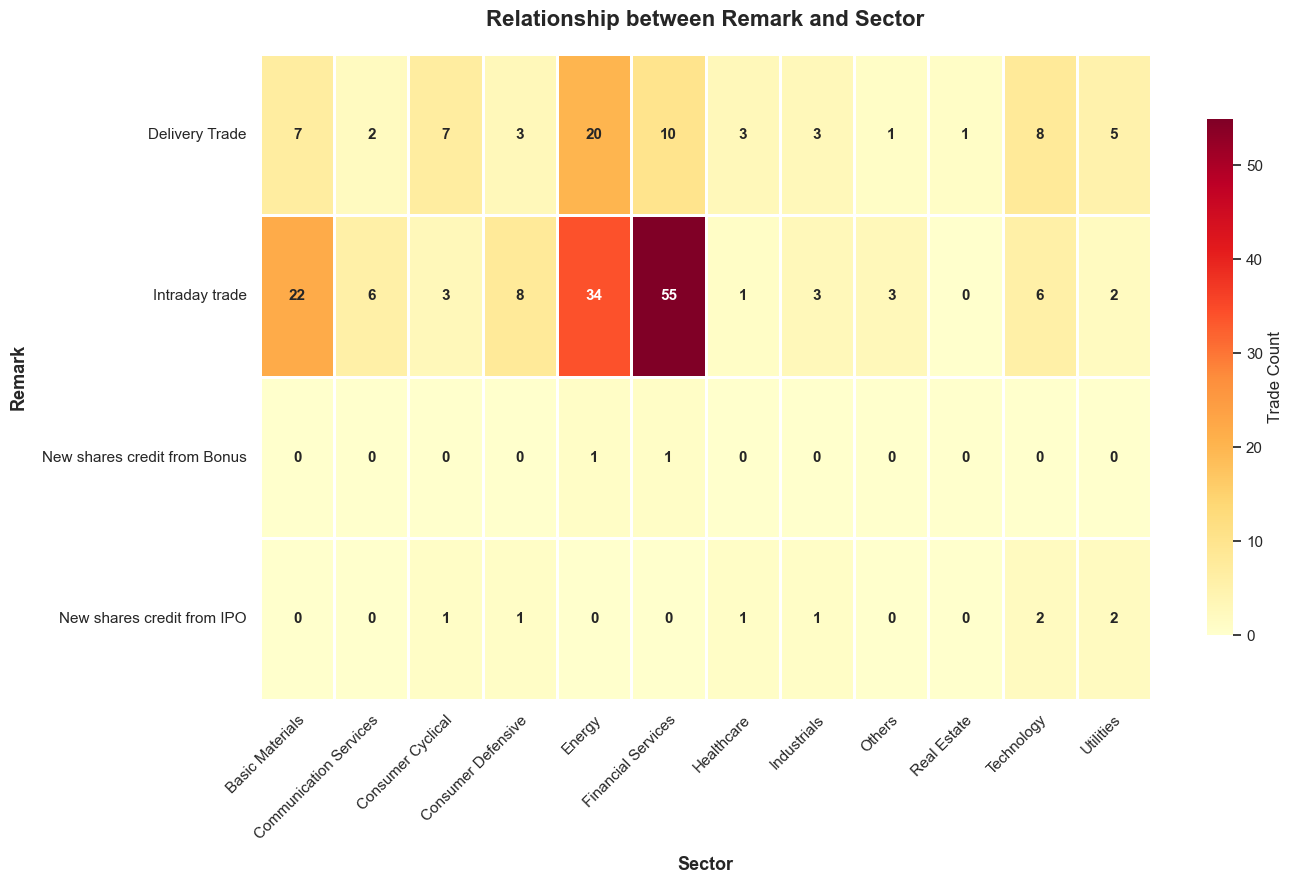

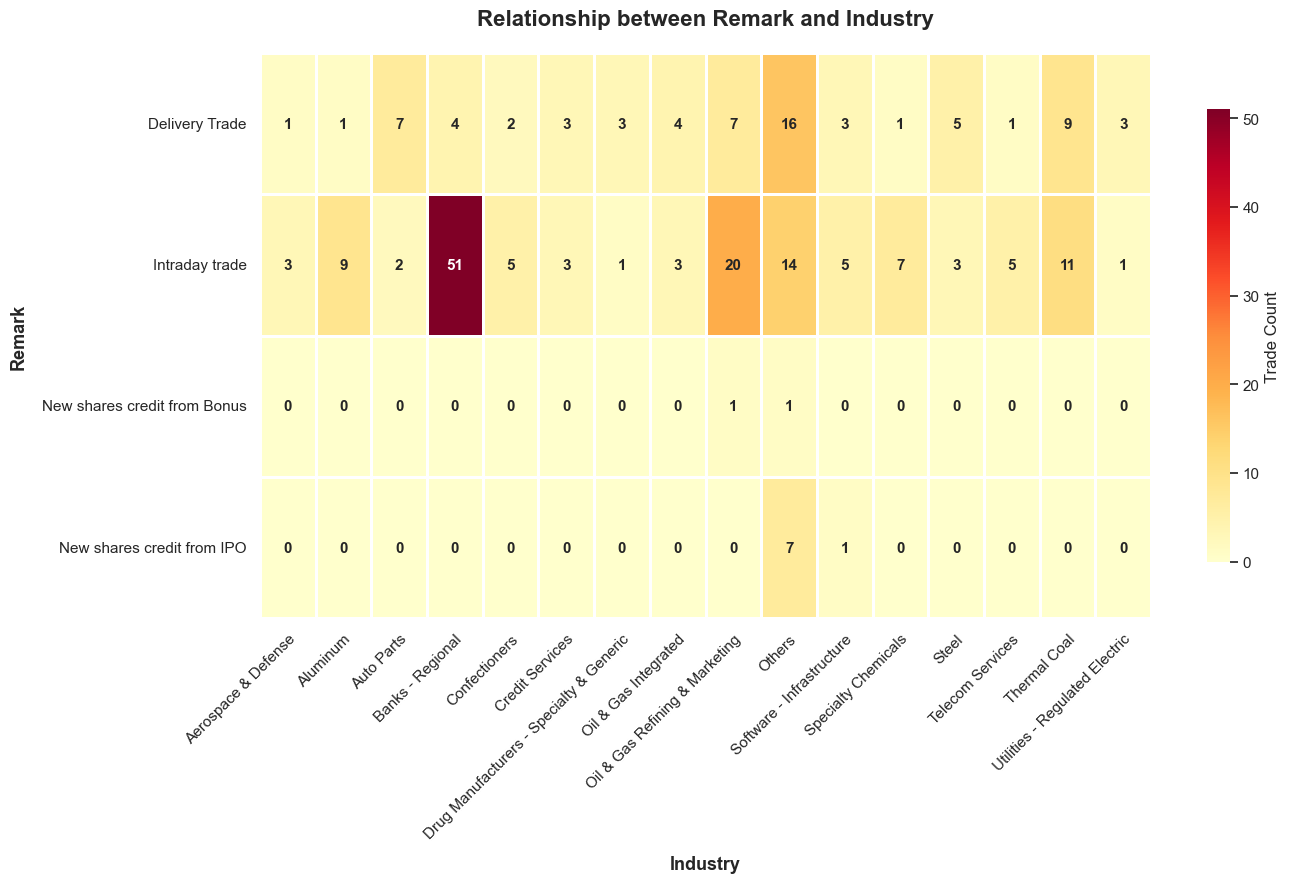

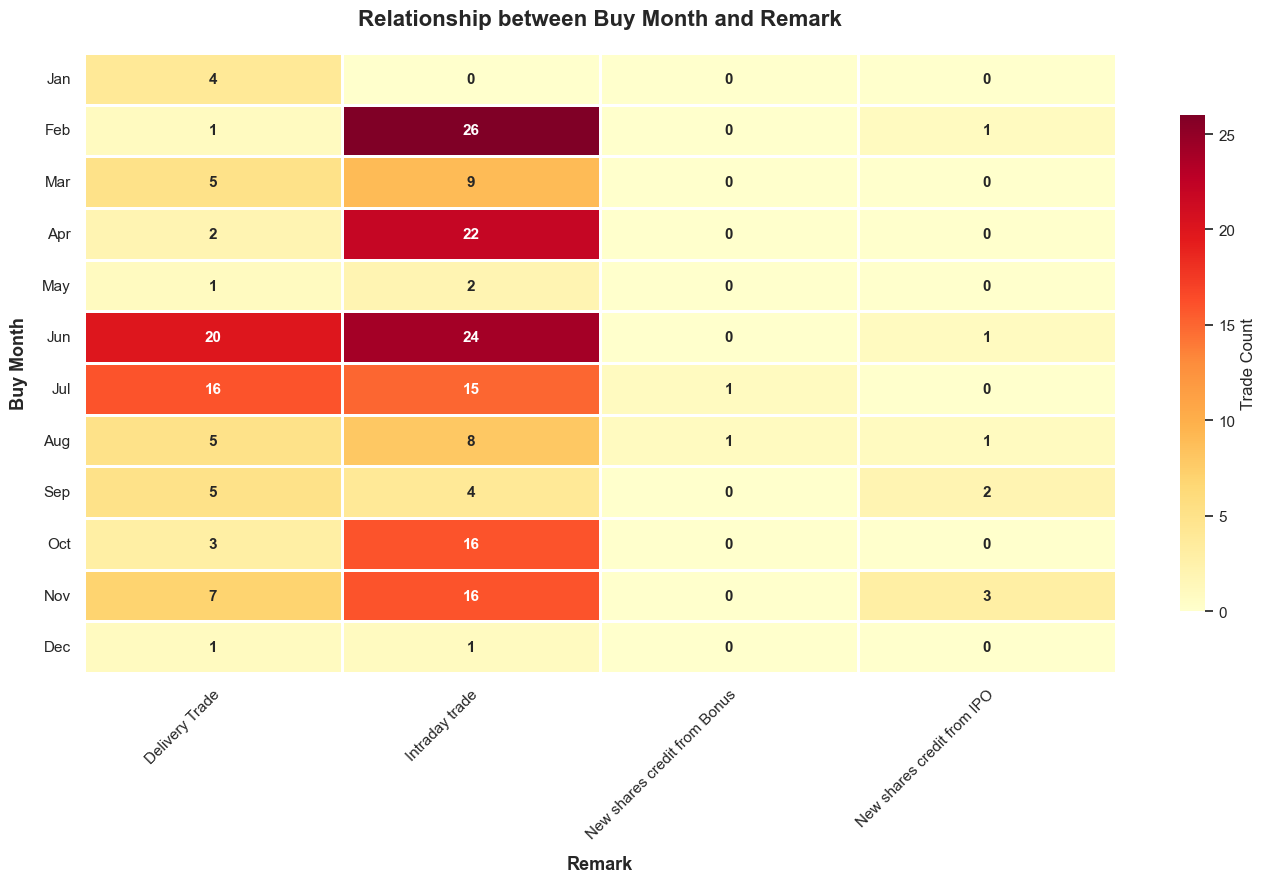

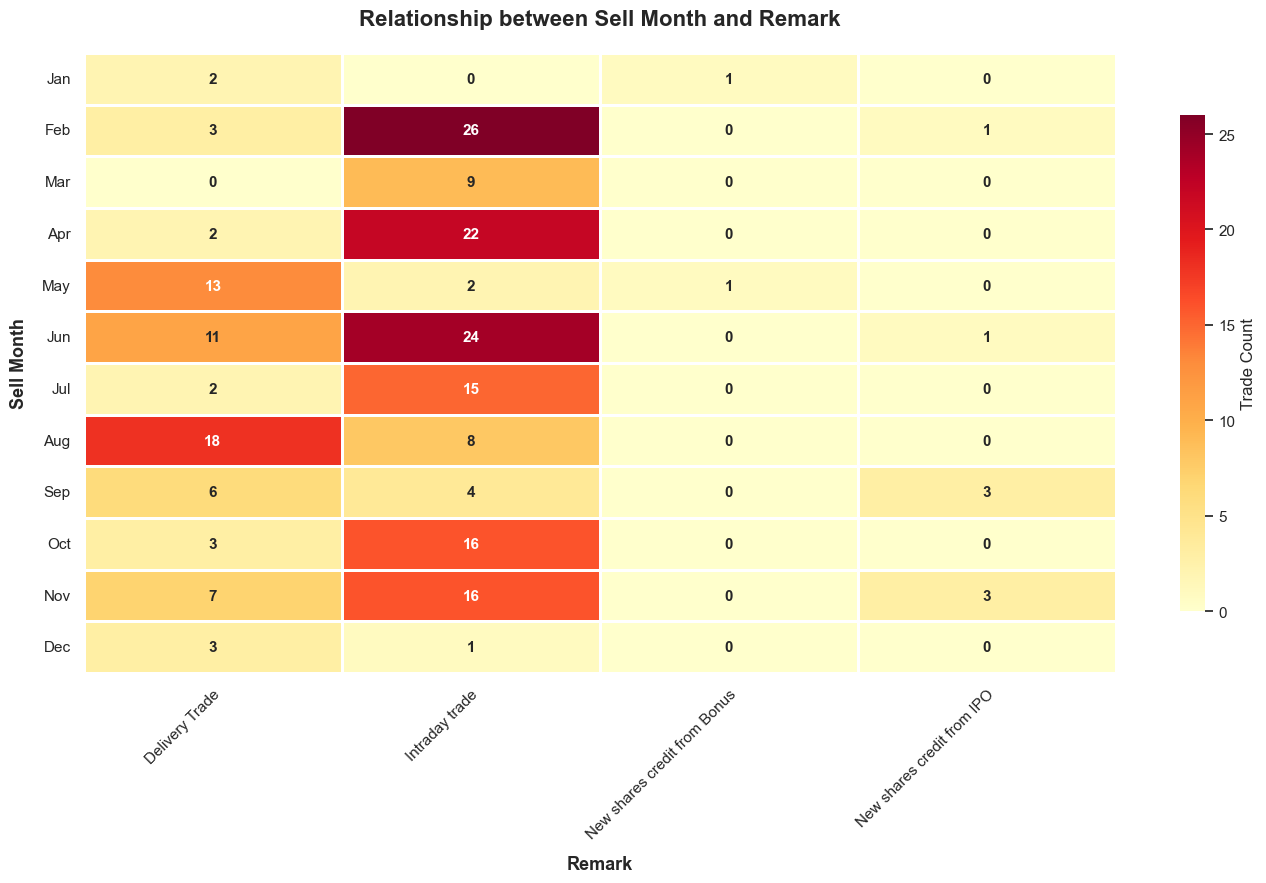

In [1752]:
important_pairs = [
    ('Buy Month', 'Sell Month'),
    ('Buy Month', 'Sector'),
    ('Sell Month', 'Sector'),
    ('Remark', 'Sector'),
    ('Remark', 'Industry'),
    ('Buy Month', 'Remark'),
    ('Sell Month', 'Remark')
]

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for col1, col2 in important_pairs:
    if col1 in pnl.columns and col2 in pnl.columns:
        if pnl[col1].nunique() <= 20 and pnl[col2].nunique() <= 20:
            
            if col1 in ['Buy Month', 'Sell Month']:
                pnl_temp = pnl[pnl[col1].isin(month_order)].copy()
                pnl_temp[col1] = pd.Categorical(pnl_temp[col1], categories=month_order, ordered=True)
            else:
                pnl_temp = pnl.copy()
            
            if col2 in ['Buy Month', 'Sell Month']:
                pnl_temp = pnl_temp[pnl_temp[col2].isin(month_order)].copy()
                pnl_temp[col2] = pd.Categorical(pnl_temp[col2], categories=month_order, ordered=True)
            
            cross_tab = pd.crosstab(pnl_temp[col1], pnl_temp[col2])
            
            fig, ax = plt.subplots(figsize=(14, 9))
            
            sns.heatmap(cross_tab, cmap='YlOrRd', annot=True, fmt='d', 
                       linewidths=2, linecolor='white',
                       cbar_kws={'label': 'Trade Count', 'shrink': 0.8},
                       annot_kws={'fontsize': 11, 'fontweight': 'bold'},
                       ax=ax)
            
            ax.set_title(f"Relationship between {col1} and {col2}", 
                        fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel(col2, fontsize=13, fontweight='bold', labelpad=10)
            ax.set_ylabel(col1, fontsize=13, fontweight='bold', labelpad=10)
            
            ax.tick_params(axis='x', labelsize=11, rotation=45)
            ax.tick_params(axis='y', labelsize=11, rotation=0)
            
            plt.setp(ax.get_xticklabels(), ha='right', rotation_mode='anchor')
            
            plt.tight_layout()
            plt.show()    


--------- These plots...

we can also use the Pandas Profiller to apply the EDA to the User Trade History dataset

In [1753]:
from pandas_profiling import ProfileReport
profile = ProfileReport(pnl, title="User Trade History Analysis")
profile.to_file("User Trade History Analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 748.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [1754]:
pnl.info()
print("\nValue Counts for Each Column:\n")

for col in pnl.columns:
    print(f"--- {col} ---")
    print(pnl[col].value_counts(dropna=False))  # include NaN counts
    print("\n")

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 0 to 223
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stock name        223 non-null    object 
 1   ISIN              223 non-null    object 
 2   Quantity          223 non-null    int64  
 3   Buy date          223 non-null    object 
 4   Buy price         223 non-null    float64
 5   Buy value         223 non-null    float64
 6   Sell date         223 non-null    object 
 7   Sell price        223 non-null    float64
 8   Sell value        223 non-null    float64
 9   Realised P&L      223 non-null    float64
 10  Remark            223 non-null    object 
 11  Buy Time          223 non-null    object 
 12  Sell Time         223 non-null    object 
 13  Symbol            223 non-null    object 
 14  Sector            223 non-null    object 
 15  Industry          223 non-null    object 
 16  Buy Year          223 non-null    int64  
 17  Bu

# Feature Engineering

1. Feature Construction (Manually)

Since the realised profit and loss is not calculating the charges, taxes and brokerages paid by the user to the Broker and Exchange so we will be calculating them. 

In [1755]:
# --- Base Values ---
buy_val = pnl['Buy value']
sell_val = pnl['Sell value']
turnover = buy_val + sell_val  # total trade value

# --- Brokerage (0.05% or ₹20 per executed order whichever is lower, both sides combined) ---
pnl['Brokerage'] = (turnover * 0.0005).clip(upper=40)  # Max ₹20 per side (40 total for buy+sell)

# --- Exchange Transaction Charges (NSE EQ: 0.00345%, BSE EQ: ~0.00297%) ---
pnl['Exchange Charges'] = turnover * 0.0000297

# --- SEBI Fees (₹10 per crore) ---
pnl['SEBI Charges'] = turnover * 0.000001

# --- IPF (Investor Protection Fund) ---
pnl['Investor Protection Fund'] = turnover * 0.000001

# --- Initialize other columns ---
pnl['STT'] = 0.0
pnl['Stamp Duty'] = 0.0
pnl['Demat Charges'] = 0.0

# --- Intraday Trades ---
mask_intraday = pnl['Remark'].str.contains('Intraday', case=False, na=False)
pnl.loc[mask_intraday, 'STT'] = sell_val * 0.00025
pnl.loc[mask_intraday, 'Stamp Duty'] = buy_val * 0.00003
pnl.loc[mask_intraday, 'Demat Charges'] = 0.0

# --- Delivery Trades ---
mask_delivery = ~mask_intraday & ~pnl['Remark'].str.contains('IPO', case=False, na=False)
pnl.loc[mask_delivery, 'STT'] = sell_val * 0.001
pnl.loc[mask_delivery, 'Stamp Duty'] = buy_val * 0.00015
pnl.loc[mask_delivery, 'Demat Charges'] = 13.5 * 1.18  # apply GST directly (13.5 + 18%)

# --- IPO Trades ---
mask_ipo = pnl['Remark'].str.contains('IPO', case=False, na=False)
pnl.loc[mask_ipo, 'STT'] = sell_val * 0.001
pnl.loc[mask_ipo, 'Stamp Duty'] = 0.0
pnl.loc[mask_ipo, 'Exchange Charges'] = sell_val * 0.0000297
pnl.loc[mask_ipo, 'SEBI Charges'] = sell_val * 0.000001
pnl.loc[mask_ipo, 'Investor Protection Fund'] = sell_val * 0.000001
pnl.loc[mask_ipo, 'Demat Charges'] = 13.5 * 1.18

# --- GST (18%) ---
# Apply only on Brokerage + Exchange Charges (per GST Act)
pnl['GST'] = (pnl['Brokerage'] + pnl['Exchange Charges']) * 0.18

# --- Total Charges (Sum Everything) ---
pnl['Total Charges'] = (
    pnl['Brokerage'] +
    pnl['Exchange Charges'] +
    pnl['SEBI Charges'] +
    pnl['Investor Protection Fund'] +
    pnl['STT'] +
    pnl['Stamp Duty'] +
    pnl['Demat Charges'] +
    pnl['GST']
).round(2)

pnl['Total Charges'].sum().round(2)

np.float64(3841.64)

Now, let's find the Gross and Net pnl and pnl % to better understand the profits and losses. This will give the idea of overall profits user generates. 

In [1756]:
# Calculating the Gross and Net pnl and pnl %
pnl['Gross Realised P&L'] = pnl['Sell value'] - pnl['Buy value']
pnl['Gross Realised PnL %'] = (pnl['Gross Realised P&L'] / pnl['Buy value']) * 100
pnl['Net Realised P&L'] = pnl['Gross Realised P&L'] - pnl['Total Charges']
pnl['Net Realised PnL %'] = (pnl['Net Realised P&L'] / pnl['Buy value']) * 100
pnl = pnl.drop(columns= 'Realised P&L')

Now, let's find the holding period to understand the user's preference and find the most profitable holding period for the user.

In [1757]:
# Ensure both date columns are proper datetime objects
pnl['Buy date'] = pd.to_datetime(pnl['Buy date'], errors='coerce')
pnl['Sell date'] = pd.to_datetime(pnl['Sell date'], errors='coerce')

# Now safely calculate holding period
pnl['Holding Period (Days)'] = (pnl['Sell date'] - pnl['Buy date']).dt.days

2. Feature Transformation

In [1758]:
pnl.info()
pnl.head(10)
pnl.shape

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 0 to 223
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Stock name                223 non-null    object        
 1   ISIN                      223 non-null    object        
 2   Quantity                  223 non-null    int64         
 3   Buy date                  223 non-null    datetime64[ns]
 4   Buy price                 223 non-null    float64       
 5   Buy value                 223 non-null    float64       
 6   Sell date                 223 non-null    datetime64[ns]
 7   Sell price                223 non-null    float64       
 8   Sell value                223 non-null    float64       
 9   Remark                    223 non-null    object        
 10  Buy Time                  223 non-null    object        
 11  Sell Time                 223 non-null    object        
 12  Symbol                    2

(223, 43)